# Final Capstone: What's in the Job Title?

## Sylvia Lee 

# Statement of Problem

While looking for jobs, one important aspect is whether the salary meets job seeker’s expectation. As a result, job seekers tend to spend time on researching salaries to get a general idea of how much their skills and experience worth. To ease this process, this project builds an algorithm for a job search application. Specifically, when a job seeker identifies target job title, his/her employment length and location, this app generates an estimated annual income. In addition, this project will investigate the importance of job title in predicting salary and help us better understand the value associated with job title. This solution is valuable not only for job seekers to gauge their salary expectations, but also for recruiters to evaluate their job offers. 

# Import Libraries

In [1131]:
#basic 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
)

#regression models and evaluation
from sklearn.linear_model import (
    SGDRegressor,
    LinearRegression,
    Ridge,
    Lasso,
)

from sklearn import metrics 

#natrual language processing 
import en_core_web_lg

#dimensionality reduction 
from sklearn.decomposition import PCA

#neural network
import keras
from keras.models import Sequential
from keras.layers import Dense

#set display 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)

#set random seed
import random
random.seed(1)

# The Data

This dataset contains complete loan data for all loans issued by Lending Club through 2007-2018, including the current loan status and latest payment information. Additional features include credit scores, number of finance inquiries, and demographic information (e.g., address, employment and income). A data dictionary is aviable in a separate file. The dataset can be downloaded from [kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data).

In [2]:
loan = pd.read_csv('lending-club-loan-data/loan.csv')

pd.options.display.max_columns=1000

loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt cons

Given the purpose of the study, variables including job title, state, zip code, employment length and annual income are used in the analysis.

In [4]:
#select variables for this study
job_df = pd.DataFrame(loan[['issue_d', 'emp_title', 'emp_length', 
                            'annual_inc', 'addr_state','zip_code']])

job_df.head()

,issue_d,emp_title,emp_length,annual_inc,addr_state,zip_code
0,Dec-2018,Chef,10+ years,55000.0,NY,109xx
1,Dec-2018,Postmaster,10+ years,90000.0,LA,713xx
2,Dec-2018,Administrative,6 years,59280.0,MI,490xx
3,Dec-2018,IT Supervisor,10+ years,92000.0,WA,985xx
4,Dec-2018,Mechanic,10+ years,57250.0,MD,212xx


In [5]:
#extract year from issue date
year = []
for d in job_df['issue_d']:
    year.append(int(d.split('-')[1]))
    
job_df['year'] = year

In [6]:
job = job_df.drop(['issue_d'], axis=1)
job.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,year
0,Chef,10+ years,55000.0,NY,109xx,2018
1,Postmaster,10+ years,90000.0,LA,713xx,2018
2,Administrative,6 years,59280.0,MI,490xx,2018
3,IT Supervisor,10+ years,92000.0,WA,985xx,2018
4,Mechanic,10+ years,57250.0,MD,212xx,2018


In [7]:
#select most recent data
job18 = job[job['year']==2018]
job18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495242 entries, 0 to 495241
Data columns (total 6 columns):
emp_title     440583 non-null object
emp_length    453255 non-null object
annual_inc    495242 non-null float64
addr_state    495242 non-null object
zip_code      495242 non-null object
year          495242 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 26.4+ MB


# Exploratory Data Analysis

## Missing Data

In [8]:
job18.isnull().sum()/job18.isnull().count()

emp_title     0.110368
emp_length    0.084781
annual_inc    0.000000
addr_state    0.000000
zip_code      0.000000
year          0.000000
dtype: float64

In [9]:
job18_nomiss = job18.dropna()
job18_nomiss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440555 entries, 0 to 495241
Data columns (total 6 columns):
emp_title     440555 non-null object
emp_length    440555 non-null object
annual_inc    440555 non-null float64
addr_state    440555 non-null object
zip_code      440555 non-null object
year          440555 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 23.5+ MB


## Target Variable

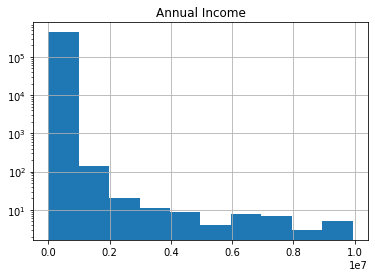

In [413]:
job18_nomiss['annual_inc'].hist()

plt.yscale('log')
plt.title('Annual Income')

plt.show()

In [421]:
job18_nomiss['annual_inc'].describe()

count    4.405550e+05
mean     8.272797e+04
std      8.725037e+04
min      0.000000e+00
25%      4.980000e+04
50%      7.000000e+04
75%      1.000000e+05
max      9.930475e+06
Name: annual_inc, dtype: float64

In [552]:
#exclude records with annual income less than 2500
job18_nomiss.drop(job18_merge[job18_merge['annual_inc']<2500].index, inplace=True)

## Employment Length 

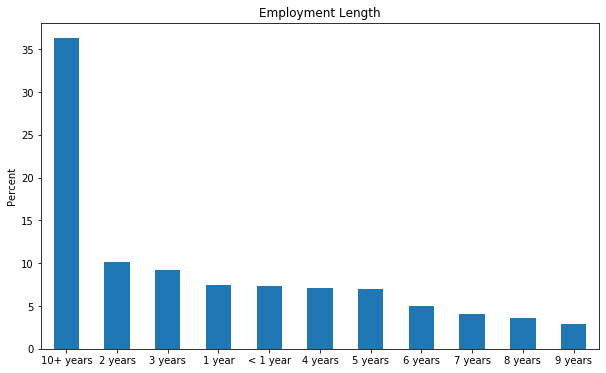

In [553]:
emplen_counts = (job18_nomiss['emp_length'] 
                 .value_counts(normalize=True)
                 .rename('Percent')
                 .mul(100)
                )

emplen_counts.plot(kind='bar', figsize=(10,6))

plt.xlabel('')
plt.ylabel('Percent')
plt.xticks(rotation=360)
plt.title('Employment Length')

plt.show()

## State

In [556]:
# 51 states: borrower's location 
state = job18_nomiss['addr_state'].value_counts().index

print('There are {} states. Note DC is also included.'.format(len(state)))
print('\n')
print(state)

There are 50 states. Note DC is also included.


Index(['CA', 'TX', 'NY', 'FL', 'IL', 'NJ', 'GA', 'PA', 'OH', 'NC', 'VA', 'MI',
       'MD', 'AZ', 'MA', 'CO', 'WA', 'IN', 'MN', 'CT', 'TN', 'MO', 'NV', 'WI',
       'SC', 'OR', 'AL', 'LA', 'KY', 'OK', 'KS', 'AR', 'UT', 'MS', 'WV', 'NH',
       'NE', 'NM', 'RI', 'HI', 'ID', 'ME', 'DE', 'MT', 'VT', 'ND', 'AK', 'DC',
       'SD', 'WY'],
      dtype='object')


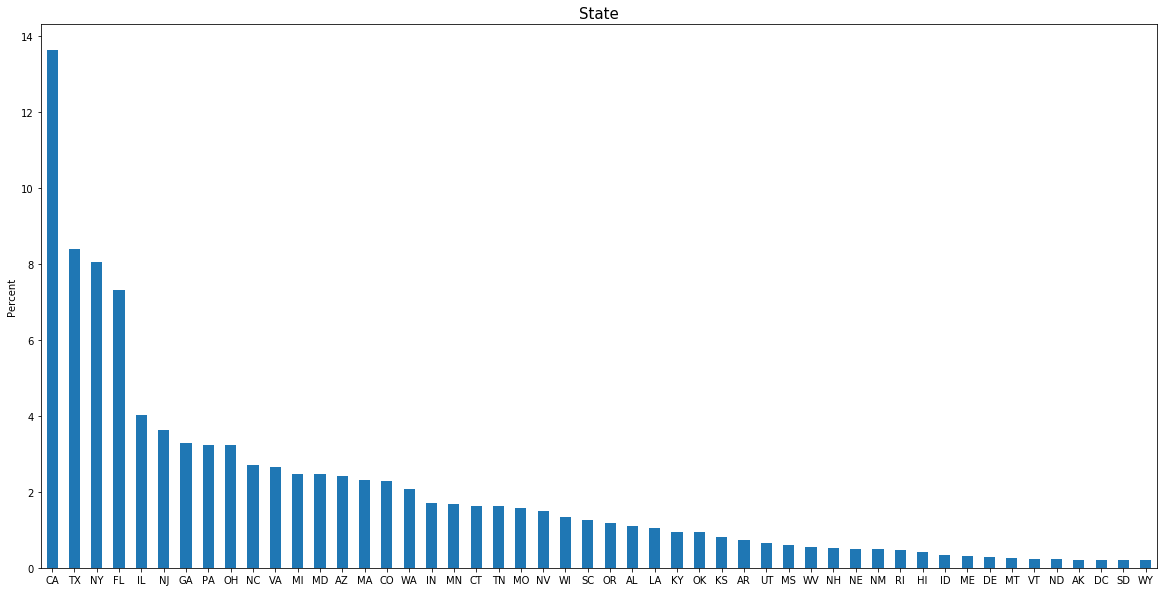

In [557]:
state_counts = (job18_nomiss['addr_state'] 
                .value_counts(normalize=True)
                .rename('Percent')
                .mul(100)
               )

state_counts.plot(kind='bar', figsize=(20,10))

plt.xlabel('')
plt.ylabel('Percent')
plt.xticks(rotation=360)
plt.title('State', fontsize=15)

plt.show()

## Zip Code 

In [558]:
job18_nomiss['zip_code'].head()

0    109xx
1    713xx
2    490xx
3    985xx
4    212xx
Name: zip_code, dtype: object

In [559]:
len(job18_nomiss['zip_code'].unique())

895

## Job Title

In [1133]:
len(job18_nomiss['emp_title'].unique())

129443

# Feature Engineering

## Employment Length

In [560]:
#change employment length to ordinal 

scale_mapper = {'< 1 year' :0,
                '1 year'   :1,
                '2 years'  :2,
                '3 years'  :3,
                '4 years'  :4,
                '5 years'  :5,
                '6 years'  :6,
                '7 years'  :7,
                '8 years'  :8,
                '9 years'  :9,
                '10+ years':10}

job18_nomiss['emp_len_ord'] = job18_nomiss['emp_length'].replace(scale_mapper)

In [561]:
job18_nomiss.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,year,emp_len_ord
0,Chef,10+ years,55000.0,NY,109xx,2018,10
1,Postmaster,10+ years,90000.0,LA,713xx,2018,10
2,Administrative,6 years,59280.0,MI,490xx,2018,6
3,IT Supervisor,10+ years,92000.0,WA,985xx,2018,10
4,Mechanic,10+ years,57250.0,MD,212xx,2018,10


## Employment Title

There are 129,443 job titles in the dataset. 

In [562]:
len(job18_nomiss['emp_title'].value_counts().index)

129443

In [563]:
job18 = job18_nomiss.copy()

In [564]:
job18.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,year,emp_len_ord
0,Chef,10+ years,55000.0,NY,109xx,2018,10
1,Postmaster,10+ years,90000.0,LA,713xx,2018,10
2,Administrative,6 years,59280.0,MI,490xx,2018,6
3,IT Supervisor,10+ years,92000.0,WA,985xx,2018,10
4,Mechanic,10+ years,57250.0,MD,212xx,2018,10


In [36]:
#remove stop_words string for creating initials
stop_words = set(stopwords.words('english'))

titles = []

for title in job18['emp_title']:
    title = "".join([c for c in title.upper() if not c in stop_words])
    titles.append(title) 
    
job18['title'] = titles 
job18.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,year,emp_len_ord,title
0,Chef,10+ years,55000.0,NY,109xx,2018,10,CHEF
1,Postmaster,10+ years,90000.0,LA,713xx,2018,10,POSTMASTER
2,Administrative,6 years,59280.0,MI,490xx,2018,6,ADMINISTRATIVE
3,IT Supervisor,10+ years,92000.0,WA,985xx,2018,10,IT SUPERVISOR
4,Mechanic,10+ years,57250.0,MD,212xx,2018,10,MECHANIC


In [40]:
initials = []

for t in job18['title']:
    
    if len(t.split()) > 1:
        initials.append(''.join([word[0] for word in t.split()]))
    else:
        initials.append(t)

job18['title_init'] = initials

job18.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,year,emp_len_ord,title,title_init
0,Chef,10+ years,55000.0,NY,109xx,2018,10,CHEF,CHEF
1,Postmaster,10+ years,90000.0,LA,713xx,2018,10,POSTMASTER,POSTMASTER
2,Administrative,6 years,59280.0,MI,490xx,2018,6,ADMINISTRATIVE,ADMINISTRATIVE
3,IT Supervisor,10+ years,92000.0,WA,985xx,2018,10,IT SUPERVISOR,IS
4,Mechanic,10+ years,57250.0,MD,212xx,2018,10,MECHANIC,MECHANIC


In [41]:
job18['title'].unique()

array(['CHEF', 'POSTMASTER ', 'ADMINISTRATIVE', ..., 'LG TERRITORY REP',
       'TRACKET', 'FOOD SERVICE MGR.'], dtype=object)

In [125]:
#look up job titles based on initital for recoding 
def lookup(a):
    return job18[''][job18['title_init'] == a].unique()[:20]

In [174]:
lookup('LMT')

array(['LICENCED MASSAGE THERAPIST', 'LICENSED MASSAGE THERAPIST',
       'LEAD MANUFACTURING TECHNICIAN ', 'LMT', 'LEAD MASSAGE THERAPIST',
       'LEAD MAMMOGRAPHY TECHNICIANMANAGER', 'LEAD METER TECH',
       'LEAD MAINTANENCE TECHNICIAN', 'LIC MASSAGE THERAPIST',
       'LEAD MAINTENANCE TECHNICIAN', 'LEAD MRI TECHNOLOGIST',
       'LICENSED MASSAGE THERAPIST ', 'LEAD MEDICAL TECHNOLOGIST',
       'LEAD MRI TECHNOLGIST', 'LEAD MEDICATION TECHNICIAN ',
       'LEAD MEDICAL TECHNOLOGIST ', 'LEAD MAINTENENCE TECH',
       'LEAD MAINTENANCE TECH', 'LEAD MECHANICAL TECHNICIAN ',
       'LEAD MRI TECH'], dtype=object)

In [177]:
Acronyms = pd.DataFrame([j.upper() for j in job18['title'] if len(j)<4], 
                         columns=['acronym'])

acr_counts = pd.DataFrame(Acronyms['acronym'].value_counts())
#acr_counts[acr_counts['acronym']<75]

In [43]:
#convert abbreviations to full title
abbrTOfull = {'RN'  : 'REGISTERED NURSE',
              'CEO' : 'CHIEF EXECUTIVE OFFICER',  
              'LPN' : 'LICENSED PRACTICAL NURSE',
              'CNA' : 'CERTIFIED NURSING ASSISTANT',
              'VP'  : 'VICE PRESIDENT',
              'CSR' : 'CUSTOMER SERVICE REPRESENTATIVE',
              'CFO' : 'CHIEF FINANCIAL OFFICER',
              'IT'  : 'INFORMATION TECHNOLOGY',
              'GM'  : 'GENERAL MANAGER',
              'COO' : 'CHIEF OPERATING OFFICER',
              'LVN' : 'LICENSED VOCATIONAL NURSE',
              'CPA' : 'CERTIFIED PUBLIC ACCOUNTANT',
              'EMT' : 'EMERGENCY MEDICAL TECHNICIAN',
              'ATT' : 'ASSEMBLY  TEST TECHNICIAN',
              'SVP' : 'SENIOR VICE PRESIDENT',
              'HR'  : 'HUMAN RESOURCE',
              'AVP' : 'ASSISTANT VICE PRESIDENT',
              'CTO' : 'CHIEF TECHNOLOGY OFFICER',
              'MGR' : 'MANAGER',
              'UPS' : 'UNITED PARCEL SERVICES',
              'PCA' : 'PATIENT CARE ASSOCIATE',
              'HHA' : 'HOME HEALTH AID',
              'CMA' : 'CERTIFIED MEDICAL ASSISTANT',
              'GS'  : 'GENERAL SCHEDULE',
              'CIO' : 'CHIEF INFORMATION OFFICER',
              'CSA' : 'CUSTOMER SERVICE ASSOCIATE',
              'DSP' : 'DIRECT SUPPORT PROFESSIONAL',
              'PTA' : 'PHYSICAL THERAPIST ASSISTANT',
              'PCT' : 'PATIENT CARE TECHNICIAN',
              'TSO' : 'TRANSPORTATION SECURITY OFFICER',
              'RCA' : 'RESIDENT CARE ASSISTANT',
              'SGT' : 'SENIOR GENERATOR TECHNICIAN',
              'EVP' : 'EXECUTIVE VICE PRESIDENT',
              'RDA' : 'REGISTERED DENTAL ASSISTANT',
              'QA'  : 'QUALITY ASSURANCE',
              'MA'  : 'MEDICAL ASSISTANT',
              'DBA' : 'DATA BASE ADMINISTRATOR',
              'ASM' : 'ASSISTANT STORE MANAGER',
              'MD'  : 'MEDICAL DOCTOR',
              'CST' : 'CLIENT SERVICES TECHNICIAN',
              'PSR' : 'PATIENT SERVICE REPRESENTATIVE',
              'PM'  : 'PROJECT MANAGER',
              'QC'  : 'QUALITY CONTROL',
              'MLT' : 'MEDICAL LABORATORY TECHNICIAN',
              'PA'  : 'PROJECT ACCOUNTANT',
              'CO'  : 'CORRECTIONS OFFICER',
              'NP'  : 'NURSE PRACTITIONER', 
              'SSG' : 'SALES SUPPORT GENERALIST',
              'CCA' : 'CITY CARRIER ASSISTANT',
              'RDH' : 'REGISTER DENTAL HYGIENIST',
              'AGM' : 'ASSISTANT GENERAL MANAGER',
              'CSS' : 'CUSTOMER SERVICE SPECIALIST',
              'RRT' : 'REGISTERED RESPIRATORY THERAPIST',
              'CSC' : 'CLIENT SERVICES COORDINATOR',
              'RSA' : 'RENTAL SALES AGENT',
              'PO'  : 'PETTY OFFICE',
              'ADP' : 'ASSOCIATE DIRECTOR  PROJECTS',
              'PSA' : 'PROGRAM SUPPORT ASSISTANT',
              'MSR' : 'MEMBER SERVICE REPRESENTATIVE',
              'AP'  : 'ACCOUNTS PAYABLE',
              'LMT' : 'LEAD MAINTANENCE TECHNICIAN'
              }

job18['job_title'] = job18['title'].replace(abbrTOfull)

Use spaCy large English model to generate numeric representation of each job title. 

In [47]:
nlp = en_core_web_lg.load()

vectors = np.array([z for z in job18['job_title'].apply(lambda x: nlp(x).vector).values])

job18_vect = pd.DataFrame(vectors, index=job18.index)

In [48]:
#300 dimensions 
job18_vect.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.190910,-0.286760,0.325610,-0.815440,0.50561,0.789190,0.788340,-0.39848,-0.017570,1.94030,-0.313080,-0.182890,-0.663090,-0.175520,0.317470,-0.655040,-0.140740,0.299810,0.38202,-0.232040,0.303510,-0.763660,-0.111010,-0.64170,-0.033541,-0.128460,-0.501360,-0.015983,0.10591,-0.426710,0.130870,0.026202,0.515460,-0.289230,0.059983,0.009892,0.04636,0.212440,0.173100,0.035994,-0.145900,-0.057951,0.510350,0.172670,-0.304220,0.397510,0.188770,-0.183560,0.368910,0.188090,0.735200,-0.351190,0.389070,-0.173300,-0.35511,-0.026707,0.656560,0.298840,0.316510,-0.237890,0.027511,-0.766830,0.302560,-0.211390,-0.071572,-0.927050,-0.106020,0.265470,0.273090,0.412170,-0.134510,0.118100,-0.997500,0.160750,-0.530930,-0.136850,-0.166190,-0.152140,-0.120230,-0.031406,-0.238970,-0.254030,0.227140,-0.191100,0.180150,0.141130,-0.082735,0.62571,-0.300090,-0.091662,-0.401470,-0.470410,-0.242360,0.048399,0.279390,-0.50339,-0.063382,-0.032434,0.327530,-0.073080,-1.021000,-0.110610,0.173580,-0.111420,-0.342630,-0.210050,0.502750,0.025741,0.91297,-0.166160,-0.410500,-0.419250,0.006510,0.580270,0.268720,-0.171990,0.20222,-0.222170,0.285270,-0.614790,-0.323220,0.089815,0.643710,-0.061152,0.733930,-0.806350,0.351740,-0.39374,0.003497,-0.327580,-0.570030,-0.305700,0.528990,-0.028405,-0.443130,-0.548490,-0.031403,-0.432400,0.26411,-0.110030,-1.67260,-0.174710,0.067880,-0.092751,0.000114,-0.68698,-0.072147,0.392360,-0.212710,0.014920,0.43832,-0.28168,-0.298240,0.048129,0.408940,-0.250300,0.013656,0.105660,0.072425,0.307070,0.030293,0.017543,0.063263,-0.516100,0.52079,-0.266250,0.211680,-0.490870,0.32300,-0.520870,-0.406350,-0.345650,-0.411040,-0.652740,-0.462660,0.368710,-0.062423,0.344170,-0.276070,-0.013636,0.257820,-0.291640,0.269290,-0.409600,-0.002749,-0.092616,0.455230,0.504360,-0.250110,-0.157120,-0.911980,0.194040,-0.663150,-0.304280,-0.211150,0.238780,0.45002,0.124720,0.793460,-0.396190,-0.537640,-0.062362,-0.046364,-0.352420,0.174640,0.173810,-0.034390,0.483710,0.116210,-0.364940,-0.28693,0.289890,-0.262270,0.054445,0.247580,0.991940,0.401790,0.044153,-0.065543,0.368470,-0.490930,0.804380,-0.037619,0.628200,0.193940,-0.264020,0.164760,-0.488210,-0.770340,0.419030,-0.617410,-0.545250,0.100910,0.159540,-0.109310,-0.559900,-0.460910,0.356900,0.174150,0.15984,0.750840,0.211320,0.094435,-0.166830,0.103380,0.425520,-0.030059,-0.290430,-0.670060,-0.18362,-0.115940,0.14009,-0.430010,0.00411,-0.051118,0.121530,0.323920,-0.096465,0.125730,-0.156810,-0.311130,-0.107590,-0.153100,-0.556860,-0.600560,0.22116,-0.294710,-0.013135,-1.21550,-0.162770,-0.701360,0.304690,0.365420,0.413190,-0.138370,-0.06773,-0.376150,0.007521,0.49900,0.455200,0.207450,0.643930,-0.012429,0.069012,0.225950,-0.22809,0.343280,0.662990,-0.088891,0.011584,1.667900,0.594810,-0.33095,0.634600,-0.249460,-0.049259,0.577790,-0.301660,0.252980,-0.228150
1,0.234640,0.698470,-0.400190,-0.652680,-0.04554,0.095587,0.021045,-0.91542,-

In [59]:
#merge vectors to dataset
job18_merge = pd.concat([job18, job18_vect], axis=1)
job18_merge.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,year,emp_len_ord,title,title_init,job_title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,Chef,10+ years,55000.0,NY,109xx,2018,10,CHEF,CHEF,CHEF,-0.190910,-0.286760,0.325610,-0.815440,0.50561,0.789190,0.788340,-0.39848,-0.017570,1.94030,-0.313080,-0.182890,-0.663090,-0.175520,0.317470,-0.655040,-0.140740,0.299810,0.38202,-0.232040,0.303510,-0.763660,-0.111010,-0.64170,-0.033541,-0.128460,-0.501360,-0.015983,0.10591,-0.426710,0.130870,0.026202,0.515460,-0.289230,0.059983,0.009892,0.04636,0.212440,0.173100,0.035994,-0.145900,-0.057951,0.510350,0.172670,-0.304220,0.397510,0.188770,-0.183560,0.368910,0.188090,0.735200,-0.351190,0.389070,-0.173300,-0.35511,-0.026707,0.656560,0.298840,0.316510,-0.237890,0.027511,-0.766830,0.302560,-0.211390,-0.071572,-0.927050,-0.106020,0.265470,0.273090,0.412170,-0.134510,0.118100,-0.997500,0.160750,-0.530930,-0.136850,-0.166190,-0.152140,-0.120230,-0.031406,-0.238970,-0.254030,0.227140,-0.191100,0.180150,0.141130,-0.082735,0.62571,-0.300090,-0.091662,-0.401470,-0.470410,-0.242360,0.048399,0.279390,-0.50339,-0.063382,-0.032434,0.327530,-0.073080,-1.021000,-0.110610,0.173580,-0.111420,-0.342630,-0.210050,0.502750,0.025741,0.91297,-0.166160,-0.410500,-0.419250,0.006510,0.580270,0.268720,-0.171990,0.20222,-0.222170,0.285270,-0.614790,-0.323220,0.089815,0.643710,-0.061152,0.733930,-0.806350,0.351740,-0.39374,0.003497,-0.327580,-0.570030,-0.305700,0.528990,-0.028405,-0.443130,-0.548490,-0.031403,-0.432400,0.26411,-0.110030,-1.67260,-0.174710,0.067880,-0.092751,0.000114,-0.68698,-0.072147,0.392360,-0.212710,0.014920,0.43832,-0.28168,-0.298240,0.048129,0.408940,-0.250300,0.013656,0.105660,0.072425,0.307070,0.030293,0.017543,0.063263,-0.516100,0.52079,-0.266250,0.211680,-0.490870,0.32300,-0.520870,-0.406350,-0.345650,-0.411040,-0.652740,-0.462660,0.368710,-0.062423,0.344170,-0.276070,-0.013636,0.257820,-0.291640,0.269290,-0.409600,-0.002749,-0.092616,0.455230,0.504360,-0.250110,-0.157120,-0.911980,0.194040,-0.663150,-0.304280,-0.211150,0.238780,0.45002,0.124720,0.793460,-0.396190,-0.537640,-0.062362,-0.046364,-0.352420,0.174640,0.173810,-0.034390,0.483710,0.116210,-0.364940,-0.28693,0.289890,-0.262270,0.054445,0.247580,0.991940,0.401790,0.044153,-0.065543,0.368470,-0.490930,0.804380,-0.037619,0.628200,0.193940,-0.264020,0.164760,-0.488210,-0.770340,0.419030,-0.617410,-0.545250,0.100910,0.159540,-0.109310,-0.559900,-0.460910,0.356900,0.174150,0.15984,0.750840,0.211320,0.094435,-0.166830,0.103380,0.425520,-0.030059,-0.290430,-0.670060,-0.18362,-0.115940,0.14009,-0.430010,0.00411,-0.051118,0.121530,0.323920,-0.096465,0.125730,-0.156810,-0.311130,-0.107590,-0.153100,-0.556860,-0.600560,0.22116,-0.294710,-0.013135,-1.21550,-0.162770,-0.701360,0.304690,0.365420,0.413190,-0.138370,-0.06773,-0.376150,0.007521,0.49900,0.455200,0.207450,0.643930,-0.012429,0.069012,0.225950,-0.22809,0.343280,0.662990,-0.088891,0.011584,1.667900,0.594810,-0

In [62]:
job18_merge = job18_merge.drop(['year', 'title', 'title_init'], axis=1)

In [63]:
#save dataset 
job18_merge.to_csv('job18_merge.csv')

In [1132]:
job_final.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,emp_len_ord,job_title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,Chef,10+ years,55000.0,NY,109xx,10,CHEF,-0.190910,-0.286760,0.325610,-0.815440,0.50561,0.789190,0.788340,-0.39848,-0.017570,1.94030,-0.313080,-0.182890,-0.663090,-0.175520,0.317470,-0.655040,-0.140740,0.299810,0.38202,-0.232040,0.303510,-0.763660,-0.111010,-0.64170,-0.033541,-0.128460,-0.501360,-0.015983,0.10591,-0.426710,0.130870,0.026202,0.515460,-0.289230,0.059983,0.009892,0.04636,0.212440,0.173100,0.035994,-0.145900,-0.057951,0.510350,0.172670,-0.304220,0.397510,0.188770,-0.183560,0.368910,0.188090,0.735200,-0.351190,0.389070,-0.173300,-0.35511,-0.026707,0.656560,0.298840,0.316510,-0.237890,0.027511,-0.766830,0.302560,-0.211390,-0.071572,-0.927050,-0.106020,0.265470,0.273090,0.412170,-0.134510,0.118100,-0.997500,0.160750,-0.530930,-0.136850,-0.166190,-0.152140,-0.120230,-0.031406,-0.238970,-0.254030,0.227140,-0.191100,0.180150,0.141130,-0.082735,0.62571,-0.300090,-0.091662,-0.401470,-0.470410,-0.242360,0.048399,0.279390,-0.50339,-0.063382,-0.032434,0.327530,-0.073080,-1.021000,-0.110610,0.173580,-0.111420,-0.342630,-0.210050,0.502750,0.025741,0.91297,-0.166160,-0.410500,-0.419250,0.006510,0.580270,0.268720,-0.171990,0.20222,-0.222170,0.285270,-0.614790,-0.323220,0.089815,0.643710,-0.061152,0.733930,-0.806350,0.351740,-0.39374,0.003497,-0.327580,-0.570030,-0.305700,0.528990,-0.028405,-0.443130,-0.548490,-0.031403,-0.432400,0.26411,-0.110030,-1.67260,-0.174710,0.067880,-0.092751,0.000114,-0.68698,-0.072147,0.392360,-0.212710,0.014920,0.43832,-0.28168,-0.298240,0.048129,0.408940,-0.250300,0.013656,0.105660,0.072425,0.307070,0.030293,0.017543,0.063263,-0.516100,0.52079,-0.266250,0.211680,-0.490870,0.32300,-0.520870,-0.406350,-0.345650,-0.411040,-0.652740,-0.462660,0.368710,-0.062423,0.344170,-0.276070,-0.013636,0.257820,-0.291640,0.269290,-0.409600,-0.002749,-0.092616,0.455230,0.504360,-0.250110,-0.157120,-0.911980,0.194040,-0.663150,-0.304280,-0.211150,0.238780,0.45002,0.124720,0.793460,-0.396190,-0.537640,-0.062362,-0.046364,-0.352420,0.174640,0.173810,-0.034390,0.483710,0.116210,-0.364940,-0.28693,0.289890,-0.262270,0.054445,0.247580,0.991940,0.401790,0.044153,-0.065543,0.368470,-0.490930,0.804380,-0.037619,0.628200,0.193940,-0.264020,0.164760,-0.488210,-0.770340,0.419030,-0.617410,-0.545250,0.100910,0.159540,-0.109310,-0.559900,-0.460910,0.356900,0.174150,0.15984,0.750840,0.211320,0.094435,-0.166830,0.103380,0.425520,-0.030059,-0.290430,-0.670060,-0.18362,-0.115940,0.14009,-0.430010,0.00411,-0.051118,0.121530,0.323920,-0.096465,0.125730,-0.156810,-0.311130,-0.107590,-0.153100,-0.556860,-0.600560,0.22116,-0.294710,-0.013135,-1.21550,-0.162770,-0.701360,0.304690,0.365420,0.413190,-0.138370,-0.06773,-0.376150,0.007521,0.49900,0.455200,0.207450,0.643930,-0.012429,0.069012,0.225950,-0.22809,0.343280,0.662990,-0.088891,0.011584,1.667900,0.594810,-0.33095,0.634600,-0.249460,-0.049259,0

In [464]:
job_final = job18_merge.copy()
job_final.shape

(440419, 307)

In [1136]:
job_feats = job_final.drop(['emp_title', 'emp_length', 'annual_inc', 
                            'addr_state','job_title'], axis=1)
job_feats.shape

(440419, 302)

# Create Train and Test Sets

In [1137]:
X = pd.get_dummies(job_feats, drop_first=True).values
y = job_final['annual_inc'].values

print(X.shape)
print(y.shape)

(440419, 1195)
(440419,)


In [445]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 308293.
Test Set Size is 132126.


# Build Models

## 1. Stochastic Gradient Descent

In [454]:
#store results here  to modify in final
RS_train, RMSE_train, RS_test, RMSE_test, model, notes,\
Loss, Alpha, Eta0, Learning_Rate, L1_Ratio\
= [],[],[],[],[],[],[],[],[],[],[]

In [455]:
#fit SGD default model
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

pred_train = sgd.predict(X_train)
pred_test = sgd.predict(X_test)

rsqr_train = sgd.score(X_train, y_train)
rsqr_test = sgd.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

model.append('SGD')

#these are default values 
    
Loss.append('squared_loss')
Alpha.append(0.0001)
Eta0.append(0.01)
Learning_Rate.append('invscaling')
L1_Ratio.append(0.15)
notes.append('')

In [456]:
data = {'RS_train': RS_train, 'RS_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test,
        'Loss': Loss, 'Alpha': Alpha, 'Eta0': Eta0, 'Notes': notes}

print ("Summary Statistics:")

t1 = pd.DataFrame(data=data, index=model)
t1.sort_values(['RMSE_test'], ascending=True)

Summary Statistics:


,RS_train,RS_test,RMSE_train,RMSE_test,Loss,Alpha,Eta0,Notes
SGD,0.106798,0.111976,83620.777472,79458.475702,squared_loss,0.0001,0.01,


In [457]:
t1.to_csv('results_sgd.csv')

SGD: PCA on zip code

In [458]:
job_feats.shape

(440419, 302)

In [459]:
job_sub = pd.DataFrame(job_feats[['zip_code']], index=job_feats.index)
job_sub = pd.get_dummies(job_sub, drop_first=True)
job_sub.head()

,zip_code_011xx,zip_code_012xx,zip_code_013xx,zip_code_014xx,zip_code_015xx,zip_code_016xx,zip_code_017xx,zip_code_018xx,zip_code_019xx,zip_code_020xx,zip_code_021xx,zip_code_022xx,zip_code_023xx,zip_code_024xx,zip_code_025xx,zip_code_026xx,zip_code_027xx,zip_code_028xx,zip_code_029xx,zip_code_030xx,zip_code_031xx,zip_code_032xx,zip_code_033xx,zip_code_034xx,zip_code_035xx,zip_code_036xx,zip_code_037xx,zip_code_038xx,zip_code_039xx,zip_code_040xx,zip_code_041xx,zip_code_042xx,zip_code_043xx,zip_code_044xx,zip_code_045xx,zip_code_046xx,zip_code_047xx,zip_code_048xx,zip_code_049xx,zip_code_050xx,zip_code_051xx,zip_code_052xx,zip_code_053xx,zip_code_054xx,zip_code_056xx,zip_code_057xx,zip_code_058xx,zip_code_059xx,zip_code_060xx,zip_code_061xx,zip_code_062xx,zip_code_063xx,zip_code_064xx,zip_code_065xx,zip_code_066xx,zip_code_067xx,zip_code_068xx,zip_code_069xx,zip_code_070xx,zip_code_071xx,zip_code_072xx,zip_code_073xx,zip_code_074xx,zip_code_075xx,zip_code_076xx,zip_code_077xx,zip_code_078xx,zip_code_079xx,zip_code_080xx,zip_code_081xx,zip_code_082xx,zip_code_083xx,zip_code_084xx,zip_code_085xx,zip_code_086xx,zip_code_087xx,zip_code_088xx,zip_code_089xx,zip_code_090xx,zip_code_091xx,zip_code_092xx,zip_code_093xx,zip_code_094xx,zip_code_095xx,zip_code_096xx,zip_code_097xx,zip_code_098xx,zip_code_100xx,zip_code_101xx,zip_code_102xx,zip_code_103xx,zip_code_104xx,zip_code_105xx,zip_code_106xx,zip_code_107xx,zip_code_108xx,zip_code_109xx,zip_code_110xx,zip_code_111xx,zip_code_112xx,zip_code_113xx,zip_code_114xx,zip_code_115xx,zip_code_116xx,zip_code_117xx,zip_code_118xx,zip_code_119xx,zip_code_120xx,zip_code_121xx,zip_code_122xx,zip_code_123xx,zip_code_124xx,zip_code_125xx,zip_code_126xx,zip_code_127xx,zip_code_128xx,zip_code_129xx,zip_code_130xx,zip_code_131xx,zip_code_132xx,zip_code_133xx,zip_code_134xx,zip_code_135xx,zip_code_136xx,zip_code_137xx,zip_code_138xx,zip_code_139xx,zip_code_140xx,zip_code_141xx,zip_code_142xx,zip_code_143xx,zip_code_144xx,zip_code_145xx,zip_code_146xx,zip_code_147xx,zip_code_148xx,zip_code_149xx,zip_code_150xx,zip_code_151xx,zip_code_152xx,zip_code_153xx,zip_code_154xx,zip_code_155xx,zip_code_156xx,zip_code_157xx,zip_code_158xx,zip_code_159xx,zip_code_160xx,zip_code_161xx,zip_code_162xx,zip_code_163xx,zip_code_164xx,zip_code_165xx,zip_code_166xx,zip_code_167xx,zip_code_168xx,zip_code_169xx,zip_code_170xx,zip_code_171xx,zip_code_172xx,zip_code_173xx,zip_code_174xx,zip_code_175xx,zip_code_176xx,zip_code_177xx,zip_code_178xx,zip_code_179xx,zip_code_180xx,zip_code_181xx,zip_code_182xx,zip_code_183xx,zip_code_184xx,zip_code_185xx,zip_code_186xx,zip_code_187xx,zip_code_188xx,zip_code_189xx,zip_code_190xx,zip_code_191xx,zip_code_193xx,zip_code_194xx,zip_code_195xx,zip_code_196xx,zip_code_197xx,zip_code_198xx,zip_code_199xx,zip_code_200xx,zip_code_201xx,zip_code_206xx,zip_code_207xx,zip_code_208xx,zip_code_209xx,zip_code_210xx,zip_code_211xx,zip_code_212xx,zip_code_214xx,zip_code_215xx,zip_code_216xx,zip_code_217xx,zip_code_218xx,zip_code_219xx,zip_code_220xx,zip_code_221xx,zip_code_222xx,zip_code_223xx,zip_code_224xx,zip_code_225xx,zip_code_226xx,zip_code_227xx,zip_code_228xx,zip_code_229xx,zip_code_230xx,zip_code_231xx,zip_code_232xx,zip_code_233xx,zip_code_234xx,zip_code_235xx,zip_code_236xx,zip_code_237xx,zip_code_238xx,zip_code_239xx,zip_code_240xx,zip_code_241xx,zip_code_242xx,zip_code_243xx,zip_code_244xx,zip_code_245xx,zip_code_246xx,zip_code_247xx,zip_code_248xx,zip_code_249xx,zip_code_250xx,zip_code_251xx,zip_code_252xx,zip_code_253xx,zip_code_254xx,zip_code_255xx,zip_code_256xx,zip_code_257xx,zip_code_258xx,zip_code_259xx,zip_code_260xx,zip_code_261xx,zip_code_262xx,zip_code_263xx,zip_code_264xx,zip_code_265xx,zip_code_266xx,zip_code_267xx,zip_code_268xx,zip_code_270xx,zip_code_271xx,zip_code_272xx,zip_code_273xx,zip_code_274xx,zip_code_275xx,zip_code_276xx,zip_code_277xx,zip_code_278xx,zip_code_279xx,zip_code_280xx,zip_code_281xx,zip_code_282xx,zip_code_283xx,zip_code_284xx,zip_code_285xx,zip_code_

In [460]:
job_sub.shape

(440419, 894)

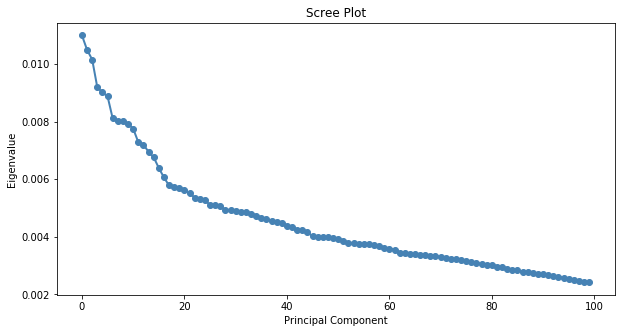

In [461]:
pca = PCA(n_components=100)
pca_components = pca.fit_transform(job_sub)

fig = plt.figure(figsize=(10,5))
sing_vals = np.arange(0, pca.n_components_, 1)
eigvals = pca.explained_variance_ratio_
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2, color='steelblue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [462]:
#keep the first two components 
pca_job = pd.DataFrame(pca_components, index=job_feats.index)
cols = ['zipcode_' + str(x) for x in range(0,100)]
pca_job.columns = cols
pca_job.head()

,zipcode_0,zipcode_1,zipcode_2,zipcode_3,zipcode_4,zipcode_5,zipcode_6,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,zipcode_12,zipcode_13,zipcode_14,zipcode_15,zipcode_16,zipcode_17,zipcode_18,zipcode_19,zipcode_20,zipcode_21,zipcode_22,zipcode_23,zipcode_24,zipcode_25,zipcode_26,zipcode_27,zipcode_28,zipcode_29,zipcode_30,zipcode_31,zipcode_32,zipcode_33,zipcode_34,zipcode_35,zipcode_36,zipcode_37,zipcode_38,zipcode_39,zipcode_40,zipcode_41,zipcode_42,zipcode_43,zipcode_44,zipcode_45,zipcode_46,zipcode_47,zipcode_48,zipcode_49,zipcode_50,zipcode_51,zipcode_52,zipcode_53,zipcode_54,zipcode_55,zipcode_56,zipcode_57,zipcode_58,zipcode_59,zipcode_60,zipcode_61,zipcode_62,zipcode_63,zipcode_64,zipcode_65,zipcode_66,zipcode_67,zipcode_68,zipcode_69,zipcode_70,zipcode_71,zipcode_72,zipcode_73,zipcode_74,zipcode_75,zipcode_76,zipcode_77,zipcode_78,zipcode_79,zipcode_80,zipcode_81,zipcode_82,zipcode_83,zipcode_84,zipcode_85,zipcode_86,zipcode_87,zipcode_88,zipcode_89,zipcode_90,zipcode_91,zipcode_92,zipcode_93,zipcode_94,zipcode_95,zipcode_96,zipcode_97,zipcode_98,zipcode_99
0,-0.006500,-0.006539,-0.009059,-0.004549,-0.004735,-0.010230,-0.002744,-0.000139,0.003142,-0.004578,-0.012715,-0.003319,-0.010908,-0.006469,-0.008294,-0.000794,-0.002058,-0.001949,-0.011719,-0.002433,-0.007499,-0.002265,-0.010036,-0.003328,-0.014742,0.003431,-0.001877,-0.014041,-0.001966,0.003704,0.008205,-0.002385,0.008481,0.010023,-0.003592,0.001265,0.004867,-0.014070,-0.005868,-0.018802,0.009043,-0.001856,0.007447,-0.013683,-0.023214,0.010717,-0.002949,-0.009312,0.005223,-0.014186,-0.021694,0.014916,0.011353,0.004076,-0.004863,0.015193,0.010530,-0.006798,-0.009545,0.013023,-0.024229,-0.015640,0.010907,0.006945,-0.029162,-0.009295,-0.010625,-0.000695,0.013169,0.006117,-0.015456,-0.028672,-0.069838,-0.064853,0.077652,-0.030354,0.041542,0.017983,0.013502,0.071784,0.032745,-0.018188,0.020420,-0.042100,-0.004596,0.022767,0.005813,0.037566,-0.034634,-0.001167,0.019033,0.031710,0.084123,-0.006734,-0.039952,-0.033062,-0.041490,0.002580,0.012176,0.048077
1,-0.005685,-0.005636,-0.007462,-0.003760,-0.003009,-0.008130,-0.002117,-0.000023,0.002210,-0.005193,-0.009567,-0.001840,-0.007004,-0.005308,-0.006394,-0.004680,-0.003684,-0.002253,-0.000455,-0.003119,-0.004153,-0.003921,-0.002123,-0.002491,-0.004312,-0.000768,-0.000919,-0.004121,-0.000920,-0.000903,-0.000285,0.002329,0.002250,-0.004062,-0.004950,-0.001048,-0.003199,-0.001581,-0.003171,-0.005566,-0.002320,-0.004684,-0.001049,-0.003117,-0.004691,0.000234,-0.001040,0.000746,0.001220,0.002049,-0.004068,-0.003884,-0.001282,-0.000284,0.000524,-0.001252,-0.000940,0.002263,-0.004849,-0.000952,-0.002077,-0.005213,-0.001052,-0.001296,0.000326,0.000758,0.000312,-0.000817,-0.003465,-0.000175,-0.001542,-0.003555,0.000324,-0.006227,0.000419,-0.004238,0.000259,0.000916,-0.002293,0.001365,-0.001715,-0.003033,-0.000291,0.002510,-0.003577,-0.003379,-0.007664,0.001558,0.000536,-0.002685,-0.003734,-0.000200,-0.002365,-0.001558,0.003187,0.002408,-0.001520,0.000249,-0.001776,0.002760
2,-0.006402,-0.006213,-0.008325,-0.004204,-0.003594,-0.009593,-0.002572,0.000322,0.002682,-0.005910,-0.011035,-0.002776,-0.008938,-0.005570,-0.007920,-0.005488,-0.002478,-0.004062,-0.001372,-0.003342,-0.005839,-0.005337,-0.002114,-0.004334,-0.005270,0.002816,-0.002016,-0.004859,-0.003152,0.001371,-0.003803,0.004196,0.001798,-0.003624,-0.005848,-0.000350,-0.005811,-0.005479,-0.000308,-0.014120,0.000821,-0.011160,-0.001576,-0.004093,-0.002861,-0.001146,-0.001264,-0.003253,0.007383,0.003808,-0.000867,-0.013919,0.003009,0.003212,0.005989,0.000949,-0.000182,0.014539,-0.006203,0.003407,-0.001172,-0.014047,0.008161,0.000702,-0.005994,0.012079,-0.001437,0.008731,0.007616,0.006357,-0.012572,-0.005462,0.008682,-0.022728,0.021080,0.014341,-0.001136,0.011097,-0.004747,0.001441,-0.000015,-0.025741,0.002879,0.021630,-0.017321,-0.002981,-0.003157,0.039006,0.000900,-0.017468,0.012180,-0.006194,-0.021687,-0.021270,-0.002908,0.015540,-0.003894,0.024351,-0.040637,0.001798

In [469]:
job_final_pca = pd.concat([pca_job, job_feats], axis=1)
job_final_pca = job_final_pca.drop('zip_code', axis=1)
#expect 401 cols
job_final_pca.shape

(440419, 401)

In [470]:
#define features and target
X = job_final_pca.values
y = job_final['annual_inc'].values

print(X.shape)
print(y.shape)

(440419, 401)
(440419,)


In [471]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 308293.
Test Set Size is 132126.


In [472]:
#store results here  to modify in final
RS_train, RMSE_train, RS_test, RMSE_test, model, notes,\
Loss, Alpha, Eta0, Learning_Rate, L1_Ratio\
= [],[],[],[],[],[],[],[],[],[],[]

In [473]:
#fit SGD default model
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

pred_train = sgd.predict(X_train)
pred_test = sgd.predict(X_test)

rsqr_train = sgd.score(X_train, y_train)
rsqr_test = sgd.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

model.append('SGD')

#these are default values 
    
Loss.append('squared_loss')
Alpha.append(0.0001)
Eta0.append(0.01)
Learning_Rate.append('invscaling')
L1_Ratio.append(0.15)
notes.append('PCA zipcode')

In [474]:
data = {'RS_train': RS_train, 'RS_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test,
        'Loss': Loss, 'Alpha': Alpha, 'Eta0': Eta0, 'Notes': notes}

print ("Summary Statistics:")

t2 = pd.DataFrame(data=data, index=model)

Summary Statistics:


,RS_train,RS_test,RMSE_train,RMSE_test,Loss,Alpha,Eta0,Notes
SGD,0.097839,0.103792,84039.088407,79823.785406,squared_loss,0.0001,0.01,PCA zipcode


In [476]:
t2.to_csv('results_sgd.csv', mode='a', header=False)

In [475]:
tsgd = pd.concat([t1, t2])
tsgd.sort_values(['RMSE_test'], ascending=True)

,RS_train,RS_test,RMSE_train,RMSE_test,Loss,Alpha,Eta0,Notes
SGD,0.106798,0.111976,83620.777472,79458.475702,squared_loss,0.0001,0.01,
SGD,0.097839,0.103792,84039.088407,79823.785406,squared_loss,0.0001,0.01,PCA zipcode


## 2. Ridge Regression

In [532]:
RS_train, RMSE_train, RS_test, RMSE_test,\
model, Alpha\
= [],[],[],[],[],[]

In [525]:
alpha_values = [0.001,0.01,0.1,1,10,100,1000]

for alpha in alpha_values:
    
    rr = Ridge(alpha=alpha)
    rr.fit(X_train, y_train)
    
    pred_train = rr.predict(X_train)
    pred_test = rr.predict(X_test)

    rsqr_train = rr.score(X_train, y_train)
    rsqr_test = rr.score(X_test, y_test)

    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

    RS_train.append(rsqr_train)
    RS_test.append(rsqr_test)
    RMSE_train.append(rmse_train)
    RMSE_test.append(rmse_test)

    model.append('Ridge Regression')
    
    Alpha.append(alpha)

In [530]:
data = {'RS_train': RS_train, 'RS_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test,
        'Alpha': Alpha}

ridge = pd.DataFrame(data=data, index=model)

print ("Summary Statistics:")

ridge.sort_values('RMSE_test', ascending=False)

,RS_train,RS_test,RMSE_train,RMSE_test,Alpha
Ridge Regression,0.101995,0.109346,83845.288103,79576.047734,1000.000
Ridge Regression,0.108872,0.112905,83523.626237,79416.907373,0.001
Ridge Regression,0.108872,0.112905,83523.626321,79416.875648,0.010
Ridge Regression,0.108872,0.112912,83523.633434,79416.585912,0.100
Ridge Regression,0.108867,0.112950,83523.873467,79414.861989,1.000
Ridge Regression,0.108814,0.113117,83526.371168,79407.414453,10.000
Ridge Regression,0.107937,0.113329,83567.440419,79397.884434,100.000


## 3. Lasso Regression

In [533]:
alpha_values = [0.001, 0.01, 0.1, 1,10,100,1000]

for alpha in alpha_values:
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    pred_train = lasso.predict(X_train)
    pred_test = lasso.predict(X_test)

    rsqr_train = lasso.score(X_train, y_train)
    rsqr_test = lasso.score(X_test, y_test)

    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

    RS_train.append(rsqr_train)
    RS_test.append(rsqr_test)
    RMSE_train.append(rmse_train)
    RMSE_test.append(rmse_test)

    model.append('Lasso Regression')
    
    Alpha.append(alpha)

In [542]:
data = {'RS_train': RS_train, 'RS_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test,
        'Alpha': Alpha}

lasso = pd.DataFrame(data=data, index=model)

print ("Summary Statistics:")

lasso.sort_values('RMSE_test', ascending=False)

,RS_train,RS_test,RMSE_train,RMSE_test,Alpha
Lasso Regression,0.049027,0.053070,86282.638056,82051.537668,1000.000
Lasso Regression,0.087766,0.095858,84506.989754,80176.317589,100.000
Lasso Regression,0.104915,0.110992,83708.866368,79502.480263,10.000
Lasso Regression,0.108872,0.112905,83523.626621,79416.874828,0.001
Lasso Regression,0.108872,0.112910,83523.631939,79416.649981,0.010
Lasso Regression,0.108865,0.112957,83523.974897,79414.576907,0.100
Lasso Regression,0.108616,0.113076,83535.658820,79409.239356,1.000


In [543]:
ridge_lasso = pd.concat([ridge, lasso])
ridge_lasso.sort_values('RMSE_test', ascending=False)

,RS_train,RS_test,RMSE_train,RMSE_test,Alpha
Lasso Regression,0.049027,0.053070,86282.638056,82051.537668,1000.000
Lasso Regression,0.087766,0.095858,84506.989754,80176.317589,100.000
Ridge Regression,0.101995,0.109346,83845.288103,79576.047734,1000.000
Lasso Regression,0.104915,0.110992,83708.866368,79502.480263,10.000
Ridge Regression,0.108872,0.112905,83523.626237,79416.907373,0.001
Ridge Regression,0.108872,0.112905,83523.626321,79416.875648,0.010
Lasso Regression,0.108872,0.112905,83523.626621,79416.874828,0.001
Lasso Regression,0.108872,0.112910,83523.631939,79416.649981,0.010
Ridge Regression,0.108872,0.112912,83523.633434,79416.585912,0.100
Ridge Regression,0.108867,0.112950,83523.873467,79414.861989,1.000


In [576]:
ridge_lasso.to_csv('ridge_lasso.csv')

## 4. Neural Network Model

### 4.1 2-Layer Neural Network

In [536]:
X = pd.get_dummies(job_feats, drop_first=True).values
y = job_final['annual_inc'].values

print(X.shape)
print(y.shape)

(440419, 1195)
(440419,)


In [537]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 308293.
Test Set Size is 132126.


In [538]:
RS_train, RMSE_train, RS_test, RMSE_test, Model, layer\
= [],[],[],[],[],[]

In [513]:
#2-layer Neural network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 128)               153088    
_________________________________________________________________
dense_92 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 65        
Total params: 161,409
Trainable params: 161,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=64, #20-100 general range
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 308293 samples, validate on 132126 samples
Epoch 1/100
308293/308293 [==============================] - 21s 67us/step - loss: 7945414660.7606 - mse: 7945418752.0000 - val_loss: 6603576469.9059 - val_mse: 6603578368.0000
Epoch 2/100
308293/308293 [==============================] - 21s 69us/step - loss: 7235509126.5280 - mse: 7235511808.0000 - val_loss: 6457125223.3971 - val_mse: 6457123840.0000
Epoch 3/100
308293/308293 [==============================] - 23s 74us/step - loss: 7122824131.8226 - mse: 7122827264.0000 - val_loss: 6372773736.9316 - val_mse: 6372777472.0000
Epoch 4/100
308293/308293 [==============================] - 23s 76us/step - loss: 7054248192.9022 - mse: 7054249984.0000 - val_loss: 6330179610.0425 - val_mse: 6330179584.0000
Epoch 5/100
308293/308293 [==============================] - 25s 80us/step - loss: 7009246613.7333 - mse: 7009243648.0000 - val_loss: 6290733447.8451 - val_mse: 6290738176.0000
Epoch 6/100
308293/308293 [==============================] - 21

In [515]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

y1 = pd.DataFrame(y_train, columns=['y_train'])
y2 = pd.DataFrame(pred_train, columns=['pred_train'])
train = pd.concat([y1, y2], axis=1)

y3 = pd.DataFrame(y_test, columns=['y_test'])
y4 = pd.DataFrame(pred_test, columns=['pred_test'])
test = pd.concat([y3, y4], axis=1)

rsqr_train = (train.corr().iloc[0,1])**2
rsqr_test = (test.corr().iloc[0,1])**2

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

Model.append('Neural Network')

layer.append(2)

In [ ]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Epochs':100, 'Layers':layer}
        

n1 = pd.DataFrame(data=data, index=Model)

### 4.2. 3-Layer Neural Network

In [484]:
RS_train, RMSE_train, RS_test, RMSE_test, Model, layer\
= [],[],[],[],[],[]

In [485]:
X = pd.get_dummies(job_feats, drop_first=True).values
y = job18_merge['annual_inc'].values

print(X.shape)
print(y.shape)

(440419, 1195)
(440419,)


In [486]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 308293.
Test Set Size is 132126.


In [487]:
#add more layers 
model = Sequential()

# The Input Layer :
model.add(Dense(128, input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='relu'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 128)               153088    
_________________________________________________________________
dense_74 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_75 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 65        
Total params: 165,569
Trainable params: 165,569
Non-trainable params: 0
_________________________________________________________________


In [488]:
history = model.fit(X_train, y_train,
                    batch_size=64, #20-100 general range
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 308293 samples, validate on 132126 samples
Epoch 1/100
308293/308293 [==============================] - 30s 98us/step - loss: 32840.6460 - mean_absolute_error: 32840.6602 - val_loss: 29713.7244 - val_mean_absolute_error: 29713.7227
Epoch 2/100
308293/308293 [==============================] - 25s 82us/step - loss: 29321.7838 - mean_absolute_error: 29321.7773 - val_loss: 29016.4742 - val_mean_absolute_error: 29016.4570
Epoch 3/100
308293/308293 [==============================] - 24s 78us/step - loss: 28842.7532 - mean_absolute_error: 28842.7324 - val_loss: 28696.6421 - val_mean_absolute_error: 28696.6680
Epoch 4/100
308293/308293 [==============================] - 25s 80us/step - loss: 28598.3795 - mean_absolute_error: 28598.3555 - val_loss: 28557.6089 - val_mean_absolute_error: 28557.5996
Epoch 5/100
308293/308293 [==============================] - 27s 86us/step - loss: 28435.3662 - mean_absolute_error: 28435.3789 - val_loss: 28424.3200 - val_mean_absolute_error: 28424.2969
Epo

Epoch 44/100
308293/308293 [==============================] - 23s 76us/step - loss: 24910.9838 - mean_absolute_error: 24910.9766 - val_loss: 27419.7665 - val_mean_absolute_error: 27419.7559
Epoch 45/100
308293/308293 [==============================] - 23s 75us/step - loss: 24842.3810 - mean_absolute_error: 24842.3828 - val_loss: 27447.4013 - val_mean_absolute_error: 27447.3965
Epoch 46/100
308293/308293 [==============================] - 27s 86us/step - loss: 24773.7502 - mean_absolute_error: 24773.7441 - val_loss: 27486.7765 - val_mean_absolute_error: 27486.7695
Epoch 47/100
308293/308293 [==============================] - 23s 75us/step - loss: 24701.6267 - mean_absolute_error: 24701.6484 - val_loss: 27423.2224 - val_mean_absolute_error: 27423.2324
Epoch 48/100
308293/308293 [==============================] - 23s 75us/step - loss: 24639.0041 - mean_absolute_error: 24638.9941 - val_loss: 27532.8496 - val_mean_absolute_error: 27532.8555
Epoch 49/100
308293/308293 [======================

In [489]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

y1 = pd.DataFrame(y_train, columns=['y_train'])
y2 = pd.DataFrame(pred_train, columns=['pred_train'])
train = pd.concat([y1, y2], axis=1)

y3 = pd.DataFrame(y_test, columns=['y_test'])
y4 = pd.DataFrame(pred_test, columns=['pred_test'])
test = pd.concat([y3, y4], axis=1)

rsqr_train = (train.corr().iloc[0,1])**2
rsqr_test = (test.corr().iloc[0,1])**2

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

Model.append('Neural Network')

layer.append(3)

In [ ]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Epochs': 100, 'Layers': layer, 'notes': ''}
        

n2 = pd.DataFrame(data=data, index=Model)

### 4.3. 4-Layer Neural Network

In [498]:
RS_train, RMSE_train, RS_test, RMSE_test, Model, layer\
= [],[],[],[],[],[]

In [491]:
#add more layers 
model = Sequential()

# The Input Layer :
model.add(Dense(128, input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='relu'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 128)               153088    
_________________________________________________________________
dense_78 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 65        
Total params: 169,729
Trainable params: 169,729
Non-trainable params: 0
_________________________________________________________________


In [492]:
history = model.fit(X_train, y_train,
                    batch_size=64, #20-100 general range
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 308293 samples, validate on 132126 samples
Epoch 1/100
308293/308293 [==============================] - 23s 74us/step - loss: 31630.3007 - mean_absolute_error: 31630.2871 - val_loss: 29304.3904 - val_mean_absolute_error: 29304.4062
Epoch 2/100
308293/308293 [==============================] - 23s 73us/step - loss: 28843.0251 - mean_absolute_error: 28843.0059 - val_loss: 29006.3060 - val_mean_absolute_error: 29006.2715
Epoch 3/100
308293/308293 [==============================] - 22s 70us/step - loss: 28503.1285 - mean_absolute_error: 28503.1582 - val_loss: 28512.3607 - val_mean_absolute_error: 28512.3535
Epoch 4/100
308293/308293 [==============================] - 21s 69us/step - loss: 28315.1237 - mean_absolute_error: 28315.1406 - val_loss: 28280.3914 - val_mean_absolute_error: 28280.4238
Epoch 5/100
308293/308293 [==============================] - 21s 69us/step - loss: 28171.8726 - mean_absolute_error: 28171.9160 - val_loss: 28143.9780 - val_mean_absolute_error: 28143.9707
Epo

Epoch 44/100
308293/308293 [==============================] - 26s 86us/step - loss: 23367.2790 - mean_absolute_error: 23367.3711 - val_loss: 27992.4686 - val_mean_absolute_error: 27992.4980
Epoch 45/100
308293/308293 [==============================] - 27s 86us/step - loss: 23282.5955 - mean_absolute_error: 23282.5586 - val_loss: 27924.6017 - val_mean_absolute_error: 27924.5840
Epoch 46/100
308293/308293 [==============================] - 24s 77us/step - loss: 23210.6972 - mean_absolute_error: 23210.7344 - val_loss: 27982.9876 - val_mean_absolute_error: 27983.0039
Epoch 47/100
308293/308293 [==============================] - 25s 81us/step - loss: 23158.1583 - mean_absolute_error: 23158.1465 - val_loss: 28069.3948 - val_mean_absolute_error: 28069.4238
Epoch 48/100
308293/308293 [==============================] - 25s 82us/step - loss: 23084.6200 - mean_absolute_error: 23084.6191 - val_loss: 28169.0639 - val_mean_absolute_error: 28169.0879
Epoch 49/100
308293/308293 [======================

In [496]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

y1 = pd.DataFrame(y_train, columns=['y_train'])
y2 = pd.DataFrame(pred_train, columns=['pred_train'])
train = pd.concat([y1, y2], axis=1)

y3 = pd.DataFrame(y_test, columns=['y_test'])
y4 = pd.DataFrame(pred_test, columns=['pred_test'])
test = pd.concat([y3, y4], axis=1)

rsqr_train = (train.corr().iloc[0,1])**2
rsqr_test = (test.corr().iloc[0,1])**2

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

Model.append('Neural Network')

layer.append(4)

In [ ]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Epochs': 100, 'Layers': layer, 'notes': ''}
        

n3 = pd.DataFrame(data=data, index=Model)

### 4.4. 5-Layer Neural Network

In [499]:
#add more layers 
model = Sequential()

# The Input Layer :
model.add(Dense(128, input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='relu'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 128)               153088    
_________________________________________________________________
dense_83 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_84 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_85 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_86 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 173,889
Trainable params: 173,889
Non-trainable params: 0
_______________________________________________

In [500]:
history = model.fit(X_train, y_train,
                    batch_size=64, #20-100 general range
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 308293 samples, validate on 132126 samples
Epoch 1/100
308293/308293 [==============================] - 25s 82us/step - loss: 30994.7367 - mean_absolute_error: 30994.7285 - val_loss: 28916.6055 - val_mean_absolute_error: 28916.6094
Epoch 2/100
308293/308293 [==============================] - 25s 82us/step - loss: 28700.2606 - mean_absolute_error: 28700.2324 - val_loss: 28456.3461 - val_mean_absolute_error: 28456.3516
Epoch 3/100
308293/308293 [==============================] - 24s 77us/step - loss: 28396.5009 - mean_absolute_error: 28396.4766 - val_loss: 28347.9600 - val_mean_absolute_error: 28347.9707
Epoch 4/100
308293/308293 [==============================] - 25s 81us/step - loss: 28182.3566 - mean_absolute_error: 28182.3691 - val_loss: 28090.5334 - val_mean_absolute_error: 28090.5488
Epoch 5/100
308293/308293 [==============================] - 23s 75us/step - loss: 27819.5952 - mean_absolute_error: 27819.5703 - val_loss: 27794.4898 - val_mean_absolute_error: 27794.4727
Epo

Epoch 44/100
308293/308293 [==============================] - 22s 72us/step - loss: 22667.7461 - mean_absolute_error: 22667.7793 - val_loss: 28413.8527 - val_mean_absolute_error: 28413.8711
Epoch 45/100
308293/308293 [==============================] - 22s 72us/step - loss: 22590.6527 - mean_absolute_error: 22590.6777 - val_loss: 28510.6690 - val_mean_absolute_error: 28510.6797
Epoch 46/100
308293/308293 [==============================] - 21s 68us/step - loss: 22540.9421 - mean_absolute_error: 22540.9609 - val_loss: 28201.9274 - val_mean_absolute_error: 28201.9062
Epoch 47/100
308293/308293 [==============================] - 22s 71us/step - loss: 22466.3130 - mean_absolute_error: 22466.2480 - val_loss: 28428.3342 - val_mean_absolute_error: 28428.3379
Epoch 48/100
308293/308293 [==============================] - 22s 71us/step - loss: 22400.9621 - mean_absolute_error: 22400.9746 - val_loss: 28252.2581 - val_mean_absolute_error: 28252.2539
Epoch 49/100
308293/308293 [======================

In [501]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

y1 = pd.DataFrame(y_train, columns=['y_train'])
y2 = pd.DataFrame(pred_train, columns=['pred_train'])
train = pd.concat([y1, y2], axis=1)

y3 = pd.DataFrame(y_test, columns=['y_test'])
y4 = pd.DataFrame(pred_test, columns=['pred_test'])
test = pd.concat([y3, y4], axis=1)

rsqr_train = (train.corr().iloc[0,1])**2
rsqr_test = (test.corr().iloc[0,1])**2

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

Model.append('Neural Network')

layer.append(5)

In [ ]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Epochs': 100, 'Layers': layer}
        

n4 = pd.DataFrame(data=data, index=Model)

In [550]:
nn = pd.concat([n1,n2,n3,n4], axis=0)
nn.sort_values(['R-squared_test', 'RMSE_test'], ascending=[True,False])

,Epochs,Layers,R-squared_test,R-squared_train,RMSE_test,RMSE_train
Neural Network,100,2,0.138390,0.163642,78328.759947,80935.146111
Neural Network,100,3,0.135710,0.198844,78931.793053,79896.151685
Neural Network,100,4,0.129499,0.219975,79366.898534,78364.752133
Neural Network,100,5,0.125691,0.235002,79717.903295,77977.579478


In [551]:
nn.to_csv('results_NN.csv')

# Final Model

Since the 2-layer Neural Network model provides best accuracy, it is the final model. To use in production, this model is finally trained by the entire dataset.

In [915]:
RS, RMSE, Model, layer = [],[],[],[]

In [910]:
X = pd.get_dummies(job_feats, drop_first=True).values
y = job_final['annual_inc'].values

print(X.shape)
print(y.shape)

(440419, 1195)
(440419,)


In [897]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 352335.
Test Set Size is 88084.


In [911]:
#2-layer Neural network
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 128)               153088    
_________________________________________________________________
dense_116 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 65        
Total params: 161,409
Trainable params: 161,409
Non-trainable params: 0
_________________________________________________________________


In [913]:
history = model.fit(X, y,
                    batch_size=100, #20-100 general range
                    epochs=100,
                    verbose=1)#,
                    #validation_data=(X_test, y_test))

Epoch 1/100
440419/440419 [==============================] - 55s 124us/step - loss: 6537923417.7885 - mse: 6537922048.0000
Epoch 2/100
440419/440419 [==============================] - 54s 122us/step - loss: 6534427559.5166 - mse: 6534417408.0000
Epoch 3/100
440419/440419 [==============================] - 54s 123us/step - loss: 6532281162.0238 - mse: 6532277248.0000
Epoch 4/100
440419/440419 [==============================] - 55s 124us/step - loss: 6528776853.8024 - mse: 6528762880.0000
Epoch 5/100
440419/440419 [==============================] - 54s 123us/step - loss: 6526063883.5824 - mse: 6526052352.0000
Epoch 6/100
440419/440419 [==============================] - 55s 124us/step - loss: 6523246248.5589 - mse: 6523247104.0000
Epoch 7/100
440419/440419 [==============================] - 53s 121us/step - loss: 6520929342.5150 - mse: 6520930816.0000
Epoch 8/100
440419/440419 [==============================] - 53s 121us/step - loss: 6518877666.5360 - mse: 6518883840.0000
Epoch 9/100
4404

440419/440419 [==============================] - 57s 130us/step - loss: 6333537107.1072 - mse: 6333532672.0000
Epoch 68/100
440419/440419 [==============================] - 57s 130us/step - loss: 6331988962.8609 - mse: 6331992064.0000
Epoch 69/100
440419/440419 [==============================] - 56s 128us/step - loss: 6327790639.9099 - mse: 6327792128.0000
Epoch 70/100
440419/440419 [==============================] - 56s 128us/step - loss: 6324970414.7700 - mse: 6324965376.0000
Epoch 71/100
440419/440419 [==============================] - 56s 128us/step - loss: 6318256383.2464 - mse: 6318254080.0000
Epoch 72/100
440419/440419 [==============================] - 56s 128us/step - loss: 6318094934.9607 - mse: 6318098944.0000
Epoch 73/100
440419/440419 [==============================] - 56s 128us/step - loss: 6314650657.2537 - mse: 6314652160.0000
Epoch 74/100
440419/440419 [==============================] - 56s 127us/step - loss: 6309185797.2796 - mse: 6309179904.0000
Epoch 75/100
440419/4

In [916]:
y_pred = model.predict(X)
#pred_test = model.predict(X_test)

y1 = pd.DataFrame(y, columns=['true'])
y2 = pd.DataFrame(y_pred, columns=['pred'])
target = pd.concat([y1, y2], axis=1)

rsqr = (target.corr().iloc[0,1])**2

rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))

RS.append(rsqr)
RMSE.append(rmse)

Model.append('Neural Network')

layer.append(2)

In [927]:
data = {'R-squared': RS, 'RMSE': RMSE, 
        'Epochs': 100, 'Layers': layer}
        

final1 = pd.DataFrame(data=data, index=Model)

print('Summary Statistics for Final Model')

final1

Summary Statistics for Final Model


,R-squared,RMSE,Epochs,Layers
Neural Network,0.187824,80813.410221,100,2


The results from the final model show a r-square of 0.19 and RMSE of $81K.

# Semantic Analysis

To evaluate the importance of job title in predicting annual income. A semantic analysis is conducted to build an algorithm to predict annual salary based on job title only. Since salary varies across location, this analysis is conducted for the largest zip code in this dataset, which is Brooklyn in NY.

In [733]:
job18_merge['zip_code'].value_counts().head()

112xx    4846
750xx    4625
945xx    4484
606xx    4043
300xx    3964
Name: zip_code, dtype: int64

In [716]:
df_112 = pd.DataFrame(job18_merge[job18_merge['zip_code']=='112xx'])
df_112.head()

,emp_title,emp_length,annual_inc,addr_state,zip_code,emp_len_ord,job_title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
229,Shift Supervisor,5 years,30000.0,NY,112xx,5,SHIFT SUPERVISOR,0.075945,-0.156783,0.167727,0.257520,0.119493,0.389895,0.113348,-0.063480,-0.374495,2.14780,-0.073909,0.044462,-0.034130,0.003708,0.128291,-0.105002,0.063195,1.281585,0.023945,-0.236761,0.192516,-0.110819,-0.294050,-0.204920,0.219410,0.221372,-0.213775,-0.159745,0.374600,-0.258209,-0.062711,-0.067271,0.087281,-0.419380,0.025225,0.334690,-0.055418,0.161095,-0.266340,-0.571520,0.268155,-0.313945,-0.150885,0.009974,0.007654,-0.056787,-0.142441,-0.028264,-0.142170,-0.051494,0.857560,-0.162907,0.225964,0.383620,-0.113815,0.316160,-0.281375,0.124048,0.169095,-0.448180,-0.309845,-0.230515,0.523780,0.065425,0.454580,-0.231209,0.158608,0.291232,0.270405,-0.112503,0.019844,-0.359205,0.105929,-0.034665,-0.021411,0.246238,-0.090815,0.086154,-0.127006,0.040949,-0.076956,-0.373405,-0.030819,-0.090610,0.148940,0.384750,0.221165,0.109832,-0.129695,-0.064885,-0.123841,-0.218927,-0.113751,-0.042903,-0.131105,-0.350155,0.295705,-0.066314,-0.073014,0.333115,-0.166185,-0.070530,0.183276,0.168696,-0.100324,-1.179375,0.087023,-0.181270,-0.380914,0.075375,-0.194810,-0.123742,-0.097295,0.442020,0.426114,-0.135345,0.098865,-0.228430,0.223660,-0.039894,-0.328645,-0.203869,0.067645,0.293530,-0.059454,-0.014927,0.161295,0.238755,-0.238080,0.010820,-0.000460,0.469300,-0.025440,-0.100350,0.237253,0.055910,0.018450,0.165121,-0.297785,0.016810,-0.064405,0.010780,-0.077445,0.082214,-0.316830,0.128880,-0.229709,-0.110712,-0.365820,-0.543665,-0.369225,-0.346405,-0.184350,0.081879,0.451318,0.235555,0.113826,-0.164475,0.314655,-0.066346,-0.178439,-0.261497,0.079823,-0.303975,-0.124005,0.217670,-0.425390,-0.014390,0.169422,-0.265105,-0.240780,0.114181,-0.260052,-0.112231,0.111616,0.294560,0.097490,0.367803,-0.126620,-0.158800,0.213200,-0.300240,-0.136856,0.189511,0.105084,0.332360,0.057202,0.075285,0.191040,-0.130571,-0.225815,0.056635,-0.001420,-0.084005,0.294509,0.175784,0.316806,-0.136895,-0.387520,-0.026040,-0.164725,0.118135,0.248510,-0.426425,-0.382650,-0.280883,0.257233,0.253179,0.496900,0.289705,0.077938,-0.036255,-0.090661,-0.125468,0.019930,0.307720,-0.263438,-0.038909,-0.155651,0.103335,0.288845,-0.173935,-0.001135,-0.036005,-0.396580,-0.000411,0.190019,0.118114,-0.099690,-0.425365,-0.755130,-0.055287,0.422255,0.282700,0.052634,0.046813,-0.208920,-0.090875,0.167149,0.179295,0.057430,-0.317780,0.164200,0.171595,-0.441085,-0.058788,-0.048334,0.090434,0.063808,-0.374580,-0.115249,0.030945,-0.227629,-0.153155,-0.258171,-0.198845,-0.148167,-0.155570,-0.165057,0.069845,0.085510,0.240063,-0.195165,-0.362450,0.073295,-0.129504,0.072571,-0.058925,0.537400,-0.159945,0.230485,-0.141070,0.177075,-0.104493,-0.178414,0.167886,0.026814,0.519515,0.278220,0.358285,-0.009140,0.020902,-0.150753,0.380595,-0.275303,-0.093730,-0.139532,0.219586,0.080101,0.141112,0.10790

In [1164]:
df_112_vars = pd.DataFrame(df_112[['annual_inc', 'job_title']])

#take off white spaces at two ends 
df_112_vars['job_title'] = df_112_vars['job_title'].str.strip()

To predict income for zip code 112xxx, the steps are as follow:
1. Sort data by annual income 
2. Segment data based on quartiles
3. Select two job titles to represent each group as reference 
4. Compute cosine similarity on the 300d word2vec vectors to determine the similarity between each job title and each reference job title
5. Use 10 similarity scores as features to predict annual income 

In [1165]:
income_by_title = pd.DataFrame(df_112_vars.groupby('job_title')['annual_inc'].mean())
income_by_title.describe()

,annual_inc
count,2359.000000
mean,80494.865207
std,57832.969976
min,10960.000000
25%,49000.000000
50%,66500.000000
75%,95166.000000
max,900000.000000


In [1166]:
income_by_title = income_by_title.sort_values('annual_inc')
income_by_title.head(10)

#create strata for annual income 
#lowest group
#choose day care provider, book seller to present this group at the bottom 

,annual_inc
job_title,
DAY CARE PROVIDER,10960.0
PASSPORT ACCEPTANCE AGENT,12000.0
DANCE TEACHER,14000.0
FULFILLMENT ASSOCIATE,14400.0
PHYSICAL THERAPY AIDE,15000.0
DAYCARE ASSISTANT,15000.0
HOMEAIDE,15000.0
COSTUMER SERVICE,16000.0
FLOOR SUPERVISOR,16000.0


In [742]:
#around 25%ile
income_by_title[income_by_title['annual_inc']<49000].tail(10)
#ADVISORY ANALYST, FINANCIAL SERVICE REP

,annual_inc
job_title,
FINANCIAL SERVICE REP,48000.000000
SOUS CHEF,48133.333333
TOXICOLOGIST,48340.000000
SECURITY OFFICER,48412.818182
SECURITY OPERATOR,48440.000000
PT. ACCESS,48462.000000
CHILDCARE,48500.000000
SALES COORDINATOR,48500.000000
ADVISORY ANALYST,48664.000000


In [744]:
#around 50%ile
income_by_title[income_by_title['annual_inc']<=66500].tail(10)
#ASSISTANT FACILITY MANAGER, SENIOR TECH ANALYST

,annual_inc
job_title,
ASSISTANT FACILITY MANAGER,66000.000000
LICENSE PRACTICAL NURSE,66000.000000
RISK ANALYST,66000.000000
EMERGENCY MEDICAL TECH,66000.000000
CONDUCTOR,66381.263158
MANGER,66500.000000
ASSISTANT COST MANAGER,66500.000000
CARRIER,66500.000000
SALES REP,66500.000000


In [747]:
#around 75%ile
income_by_title[income_by_title['annual_inc']<=95166].tail(10)
#STRATEGIST, MANAGEMENT CONSULTANT

,annual_inc
job_title,
PARAMEDIC,95000.0
AIRPORT SUPERVISOR,95000.0
SENIORTECHNICIAN,95000.0
ELECTRONIC SPECIALIST,95000.0
MANAGEMENT CONSULTANT,95000.0
GLOBAL VM MANAGER,95000.0
KYC ANALYST,95000.0
STRATEGIST,95000.0
HAIR COLORIST,95000.0


In [748]:
#top income
income_by_title.tail(10)
#SURGEON, ASSOCIATE PROFESSOR

,annual_inc
job_title,
HEAD INTERNATIONAL TRADER,375000.000000
ASSISTANCE DIRECTOR,400000.000000
ASSOCIATE ATTORNEY,415000.000000
SURGEON,475000.000000
MEDICAL OFFICE ASSISTANT,528000.000000
MANAGING DIRECTOR,736777.777778
ASSOCIATE PROFESSOR,750000.000000
GENERAL COUNSEL,750000.000000
INVESTMENT ANALYST,800000.000000


In [958]:
df_112_unititle = df_112_vars.copy()

In [959]:
df_112_unititle.sort_values('job_title', inplace=True)

df_112_unititle.drop_duplicates(subset='job_title', keep=False, inplace=True)

df_112_unititle = df_112_unititle.set_index('job_title')

In [943]:
df_112_unititle.head()

,annual_inc,job_title
226563,140000.0,1ST ASSISTANT CAMERA
185027,80000.0,3RD RAIL ELECTRICIAN
91729,80000.0,911 DISPATCHER
260042,77157.0,911 OPERATOR
38352,150000.0,A-MECHANIC


In [944]:
def similarity(v1, v2):
    norm1 = np.linalg.norm(v1) 
    norm2 = np.linalg.norm(v2)
    return v1.dot(v2)/norm1/norm2

In [945]:
def similarity_words(w1, w2):
    return similarity(nlp(w1).vector, nlp(w2).vector)

In [946]:
similarity_words('STRATEGIST', 'INVESTMENT ANALYST')

0.622948

In [953]:
df_112_sim = df_112_unititle.copy()

s1,s2,s3,s4,s5,s6,s7,s8,s9,s10 = [],[],[],[],[],[],[],[],[],[]

for title in df_112_unititle.index:
    
    s1.append(similarity_words(title, 'DAY CARE PROVIDER'))
    s2.append(similarity_words(title, 'BOOKSELLER'))
    
    s3.append(similarity_words(title, 'ADVISORY ANALYST'))
    s4.append(similarity_words(title, 'FINANCIAL SERVICE REP'))
    
    s5.append(similarity_words(title, 'ASSISTANT FACILITY MANAGER'))
    s6.append(similarity_words(title, 'SENIOR TECH ANALYST'))
    
    s7.append(similarity_words(title, 'STRATEGIST'))
    s8.append(similarity_words(title, 'MANAGEMENT CONSULTANT'))
    
    s9.append(similarity_words(title, 'SURGEON'))
    s10.append(similarity_words(title, 'INVESTMENT ANALYST'))
    

df_112_sim['s1'] = s1
df_112_sim['s2'] = s2
df_112_sim['s3'] = s3
df_112_sim['s4'] = s4
df_112_sim['s5'] = s5
df_112_sim['s6'] = s6
df_112_sim['s7'] = s7
df_112_sim['s8'] = s8
df_112_sim['s9'] = s9
df_112_sim['s10'] = s10

In [954]:
df_112_sim = df_112_sim[['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']]
df_112_sim.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
job_title,,,,,,,,,,
1ST ASSISTANT CAMERA,0.412872,0.053078,0.243212,0.403107,0.599763,0.452449,0.140008,0.368591,0.351528,0.266069
3RD RAIL ELECTRICIAN,0.347730,0.062807,0.166854,0.357005,0.364758,0.301023,0.037557,0.278186,0.239320,0.250191
911 DISPATCHER,0.242720,0.022856,0.141434,0.275760,0.317509,0.181482,0.041391,0.207027,0.157640,0.071732
911 OPERATOR,0.386238,0.040189,0.176161,0.405869,0.394638,0.223434,0.062765,0.309552,0.214014,0.211845
A-MECHANIC,0.437326,0.146049,0.164899,0.442605,0.421472,0.334074,0.102853,0.322708,0.337220,0.239915


In [963]:
df_112_sim = df_112_sim.reset_index()
merge = df_112_vars.merge(df_112_sim, how='left', on='job_title')

merge = merge[['annual_inc', 'job_title', 's1', 's2', 's3', 
               's4', 's5', 's6', 's7', 's8', 's9', 's10']]
merge.head()

,annual_inc,job_title,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,30000.0,SHIFT SUPERVISOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35140.0,CERTIFIED NURSING ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125500.0,HEAD OF OPERARIONS,0.456373,0.030963,0.284068,0.403879,0.413896,0.367444,0.129829,0.342939,0.300655,0.315270
3,72000.0,IT SERVICE DELIVERY SPECIALIST,0.782036,0.175079,0.370674,0.735361,0.549009,0.440013,0.161274,0.625576,0.387171,0.393664
4,86000.0,SECURITY MANAGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [862]:
similarity_words('SHIFT SUPERVISOR', 'INVESTMENT ANALYST')

0.32287046

In [967]:
merge = merge.dropna()
merge.shape

(1805, 12)

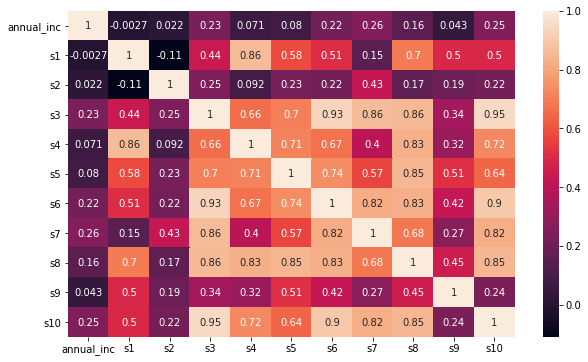

In [772]:
plt.figure(figsize=(10,6))
sns.heatmap(merge.corr(), annot=True)
plt.show()

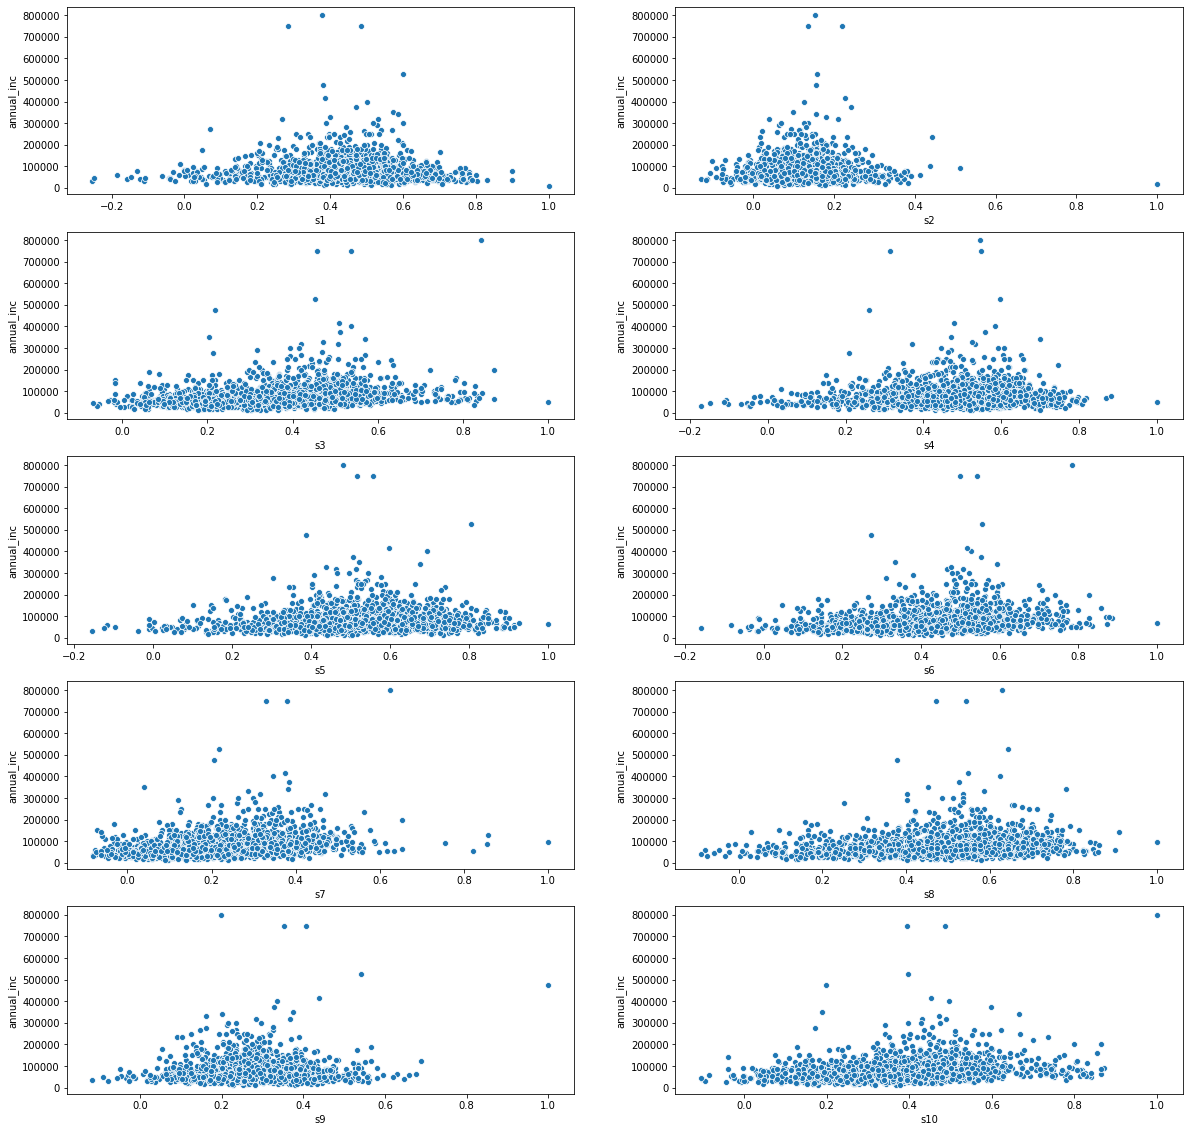

In [777]:
plt.figure(figsize=(20,20))

plt.subplot(521)
sns.scatterplot(x='s1', y='annual_inc', data=merge)
plt.subplot(522)
sns.scatterplot(x='s2', y='annual_inc', data=merge)
plt.subplot(523)
sns.scatterplot(x='s3', y='annual_inc', data=merge)
plt.subplot(524)
sns.scatterplot(x='s4', y='annual_inc', data=merge)
plt.subplot(525)
sns.scatterplot(x='s5', y='annual_inc', data=merge)
plt.subplot(526)
sns.scatterplot(x='s6', y='annual_inc', data=merge)
plt.subplot(527)
sns.scatterplot(x='s7', y='annual_inc', data=merge)
plt.subplot(528)
sns.scatterplot(x='s8', y='annual_inc', data=merge)
plt.subplot(529)
sns.scatterplot(x='s9', y='annual_inc', data=merge)
plt.subplot(5,2,10)
sns.scatterplot(x='s10', y='annual_inc', data=merge)

plt.show()

In [970]:
X = merge[['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']].values
y = merge['annual_inc'].values

In [971]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [972]:
polynomial_features= PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)

In [973]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 1263.
Test Set Size is 542.


In [974]:
#build model here for now 
#store results here 
RS_train, RMSE_train, RS_test, RMSE_test, model, features\
= [],[],[],[],[],[]

## 1. Linear Regression

In [975]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [976]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

rsqr_train = lr.score(X_train, y_train)
rsqr_test = lr.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)
model.append('Linear Regression')
features.append('10 similarity scores')

In [977]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Features': features
       }

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics:')

table

Summary Statistics:


,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Features
Linear Regression,0.107319,0.095787,55843.456752,48596.016937,10 similarity scores


Linear regression with polynomial features.

In [978]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 1263.
Test Set Size is 542.


In [979]:
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

rsqr_train = lr.score(X_train, y_train)
rsqr_test = lr.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)
model.append('Linear Regression')
features.append('10 similarity scores (Polynomial)')

In [982]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Features': features
       }

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics:')

table.sort_values('R-squared_test', ascending=False)

Summary Statistics:


,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Features
Linear Regression,0.107319,0.095787,55843.456752,48596.016937,10 similarity scores
Linear Regression,0.230766,0.038340,51838.620920,50115.953109,10 similarity scores (Polynomial)


## 2. Ridge Regression

In [983]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 1263.
Test Set Size is 542.


In [985]:
rr = Ridge()
rr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [986]:
pred_train = rr.predict(X_train)
pred_test = rr.predict(X_test)

rsqr_train = rr.score(X_train, y_train)
rsqr_test = rr.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)
model.append('Ridge Regression')
features.append('10 similarity scores')

In [987]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Features': features
       }

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics:')

table.sort_values('R-squared_test', ascending=False)

Summary Statistics:


,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Features
Ridge Regression,0.103437,0.100338,55964.748773,48473.555602,10 similarity scores
Linear Regression,0.107319,0.095787,55843.456752,48596.016937,10 similarity scores
Linear Regression,0.230766,0.038340,51838.620920,50115.953109,10 similarity scores (Polynomial)


Ridge regression with polynomial features.

In [988]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 1263.
Test Set Size is 542.


In [989]:
rr = Ridge()
rr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [990]:
pred_train = rr.predict(X_train)
pred_test = rr.predict(X_test)

rsqr_train = rr.score(X_train, y_train)
rsqr_test = rr.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)
model.append('Ridge Regression')
features.append('10 similarity scores (Polynomial)')

In [991]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Features': features
       }

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics:')

table.sort_values('RMSE_test', ascending=True)

Summary Statistics:


,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Features
Ridge Regression,0.133567,0.121688,55016.331280,47894.931576,10 similarity scores (Polynomial)
Ridge Regression,0.103437,0.100338,55964.748773,48473.555602,10 similarity scores
Linear Regression,0.107319,0.095787,55843.456752,48596.016937,10 similarity scores
Linear Regression,0.230766,0.038340,51838.620920,50115.953109,10 similarity scores (Polynomial)


## 3. Lasso Regression

In [992]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [993]:
pred_train = lasso.predict(X_train)
pred_test = lasso.predict(X_test)

rsqr_train = lasso.score(X_train, y_train)
rsqr_test = lasso.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)
model.append('Lasso Regression')
features.append('10 similarity scores')

In [994]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Features': features
       }

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics:')

table.sort_values('R-squared_test', ascending=False)

Summary Statistics:


,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Features
Ridge Regression,0.133567,0.121688,55016.331280,47894.931576,10 similarity scores (Polynomial)
Ridge Regression,0.103437,0.100338,55964.748773,48473.555602,10 similarity scores
Lasso Regression,0.211391,0.100297,52487.393107,48474.668182,10 similarity scores
Linear Regression,0.107319,0.095787,55843.456752,48596.016937,10 similarity scores
Linear Regression,0.230766,0.038340,51838.620920,50115.953109,10 similarity scores (Polynomial)


Lasso regression with polynomial features.

In [995]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 1263.
Test Set Size is 542.


In [996]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [997]:
pred_train = lasso.predict(X_train)
pred_test = lasso.predict(X_test)

rsqr_train = lasso.score(X_train, y_train)
rsqr_test = lasso.score(X_test, y_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)
model.append('Lasso Regression')
features.append('10 similarity scores (Polynomial)')

In [998]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Features': features
       }

table = pd.DataFrame(data=data, index=model)

print('Summary Statistics:')

table.sort_values('R-squared_test', ascending=False)

Summary Statistics:


,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Features
Ridge Regression,0.133567,0.121688,55016.331280,47894.931576,10 similarity scores (Polynomial)
Ridge Regression,0.103437,0.100338,55964.748773,48473.555602,10 similarity scores
Lasso Regression,0.211391,0.100297,52487.393107,48474.668182,10 similarity scores
Lasso Regression,0.211391,0.100297,52487.393107,48474.668182,10 similarity scores (Polynomial)
Linear Regression,0.107319,0.095787,55843.456752,48596.016937,10 similarity scores
Linear Regression,0.230766,0.038340,51838.620920,50115.953109,10 similarity scores (Polynomial)


## 4. Neural Network

In [1006]:
RS_train, RMSE_train, RS_test, RMSE_test, Model, layer, features\
= [],[],[],[],[],[],[]

In [1007]:
#2-layer Neural network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 128)               8576      
_________________________________________________________________
dense_119 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 65        
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [1008]:
history = model.fit(X_train, y_train,
                    batch_size=64, #20-100 general range
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 1263 samples, validate on 542 samples
Epoch 1/100
1263/1263 [==============================] - 0s 213us/step - loss: 9965014493.1370 - mse: 9965014016.0000 - val_loss: 9177743764.3100 - val_mse: 9177742336.0000
Epoch 2/100
1263/1263 [==============================] - 0s 33us/step - loss: 9964130929.5075 - mse: 9964131328.0000 - val_loss: 9176219576.2066 - val_mse: 9176219648.0000
Epoch 3/100
1263/1263 [==============================] - 0s 38us/step - loss: 9961643759.1766 - mse: 9961645056.0000 - val_loss: 9172229244.6937 - val_mse: 9172229120.0000
Epoch 4/100
1263/1263 [==============================] - 0s 31us/step - loss: 9955844513.5455 - mse: 9955843072.0000 - val_loss: 9163938944.4723 - val_mse: 9163937792.0000
Epoch 5/100
1263/1263 [==============================] - 0s 26us/step - loss: 9944723942.0554 - mse: 9944723456.0000 - val_loss: 9149078648.9151 - val_mse: 9149078528.0000
Epoch 6/100
1263/1263 [==============================] - 0s 28us/step - loss: 9925841331.382

1263/1263 [==============================] - 0s 33us/step - loss: 3735783956.4719 - mse: 3735783936.0000 - val_loss: 2866004336.4133 - val_mse: 2866004480.0000
Epoch 49/100
1263/1263 [==============================] - 0s 26us/step - loss: 3733533049.1085 - mse: 3733532928.0000 - val_loss: 2864003075.7786 - val_mse: 2864003072.0000
Epoch 50/100
1263/1263 [==============================] - 0s 25us/step - loss: 3731860402.5717 - mse: 3731860480.0000 - val_loss: 2862138630.6125 - val_mse: 2862138624.0000
Epoch 51/100
1263/1263 [==============================] - 0s 24us/step - loss: 3730395093.8401 - mse: 3730394624.0000 - val_loss: 2860233495.6162 - val_mse: 2860233472.0000
Epoch 52/100
1263/1263 [==============================] - 0s 21us/step - loss: 3728694358.3468 - mse: 3728694272.0000 - val_loss: 2858044002.2435 - val_mse: 2858044160.0000
Epoch 53/100
1263/1263 [==============================] - 0s 22us/step - loss: 3727147514.1219 - mse: 3727147520.0000 - val_loss: 2856094823.9114 - 

1263/1263 [==============================] - 0s 22us/step - loss: 3651451455.9493 - mse: 3651451392.0000 - val_loss: 2782579464.5018 - val_mse: 2782579456.0000
Epoch 96/100
1263/1263 [==============================] - 0s 23us/step - loss: 3649197814.6762 - mse: 3649198080.0000 - val_loss: 2781096908.9889 - val_mse: 2781096960.0000
Epoch 97/100
1263/1263 [==============================] - 0s 22us/step - loss: 3647025202.2676 - mse: 3647025408.0000 - val_loss: 2779633186.0074 - val_mse: 2779633408.0000
Epoch 98/100
1263/1263 [==============================] - 0s 24us/step - loss: 3645161317.3460 - mse: 3645161472.0000 - val_loss: 2777775695.3506 - val_mse: 2777775872.0000
Epoch 99/100
1263/1263 [==============================] - 0s 23us/step - loss: 3643006552.1710 - mse: 3643006720.0000 - val_loss: 2775634424.4428 - val_mse: 2775634432.0000
Epoch 100/100
1263/1263 [==============================] - 0s 25us/step - loss: 3641036532.4466 - mse: 3641037056.0000 - val_loss: 2773723379.7196 -

In [1010]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

y1 = pd.DataFrame(y_train, columns=['y_train'])
y2 = pd.DataFrame(pred_train, columns=['pred_train'])
train = pd.concat([y1, y2], axis=1)

y3 = pd.DataFrame(y_test, columns=['y_test'])
y4 = pd.DataFrame(pred_test, columns=['pred_test'])
test = pd.concat([y3, y4], axis=1)

rsqr_train = (train.corr().iloc[0,1])**2
rsqr_test = (test.corr().iloc[0,1])**2

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

Model.append('Neural Network')
layer.append(2)
features.append('10 similarity scores')

In [1011]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Epochs':100, 'Layers':layer, 'Features': features}
        

nn = pd.DataFrame(data=data, index=Model)
nn

,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Epochs,Layers,Features
Neural Network,0.031247,0.042267,60330.362445,52666.1509,100,2,10 similarity scores


In [1012]:
#split into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=101)
print('Train Set Size is {}.'.format(X_train.shape[0]))
print('Test Set Size is {}.'.format(X_test.shape[0]))

Train Set Size is 1263.
Test Set Size is 542.


In [1013]:
#2-layer Neural network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 128)               8576      
_________________________________________________________________
dense_122 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 65        
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [1014]:
history = model.fit(X_train, y_train,
                    batch_size=64, #20-100 general range
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 1263 samples, validate on 542 samples
Epoch 1/100
1263/1263 [==============================] - 0s 261us/step - loss: 9964966297.8432 - mse: 9964966912.0000 - val_loss: 9177678810.2140 - val_mse: 9177678848.0000
Epoch 2/100
1263/1263 [==============================] - 0s 28us/step - loss: 9964061072.5194 - mse: 9964060672.0000 - val_loss: 9176192408.0886 - val_mse: 9176192000.0000
Epoch 3/100
1263/1263 [==============================] - 0s 34us/step - loss: 9961664344.9818 - mse: 9961664512.0000 - val_loss: 9172519546.8044 - val_mse: 9172518912.0000
Epoch 4/100
1263/1263 [==============================] - 0s 35us/step - loss: 9956461500.7063 - mse: 9956462592.0000 - val_loss: 9165240350.2288 - val_mse: 9165241344.0000
Epoch 5/100
1263/1263 [==============================] - 0s 25us/step - loss: 9946786477.9097 - mse: 9946785792.0000 - val_loss: 9152693210.2140 - val_mse: 9152693248.0000
Epoch 6/100
1263/1263 [==============================] - 0s 42us/step - loss: 9930862347.958

1263/1263 [==============================] - 0s 33us/step - loss: 3744236847.6326 - mse: 3744237312.0000 - val_loss: 2876869533.7565 - val_mse: 2876869632.0000
Epoch 49/100
1263/1263 [==============================] - 0s 29us/step - loss: 3742002385.7862 - mse: 3742002432.0000 - val_loss: 2872641923.3063 - val_mse: 2872641792.0000
Epoch 50/100
1263/1263 [==============================] - 0s 32us/step - loss: 3738506883.5471 - mse: 3738507264.0000 - val_loss: 2870227512.6790 - val_mse: 2870227456.0000
Epoch 51/100
1263/1263 [==============================] - 0s 36us/step - loss: 3736383251.1544 - mse: 3736383488.0000 - val_loss: 2867899390.1107 - val_mse: 2867899648.0000
Epoch 52/100
1263/1263 [==============================] - 0s 32us/step - loss: 3734829633.4695 - mse: 3734829824.0000 - val_loss: 2864947039.4096 - val_mse: 2864946944.0000
Epoch 53/100
1263/1263 [==============================] - 0s 33us/step - loss: 3733218429.8717 - mse: 3733218560.0000 - val_loss: 2862802991.2325 - 

1263/1263 [==============================] - 0s 29us/step - loss: 3661728407.7150 - mse: 3661728768.0000 - val_loss: 2793215170.5978 - val_mse: 2793215232.0000
Epoch 96/100
1263/1263 [==============================] - 0s 33us/step - loss: 3660123566.7205 - mse: 3660123904.0000 - val_loss: 2791332578.7159 - val_mse: 2791332608.0000
Epoch 97/100
1263/1263 [==============================] - 0s 30us/step - loss: 3658389897.2225 - mse: 3658390016.0000 - val_loss: 2789976407.8524 - val_mse: 2789976320.0000
Epoch 98/100
1263/1263 [==============================] - 0s 34us/step - loss: 3656954133.6880 - mse: 3656954112.0000 - val_loss: 2788327210.5092 - val_mse: 2788327168.0000
Epoch 99/100
1263/1263 [==============================] - 0s 24us/step - loss: 3655386287.8353 - mse: 3655386624.0000 - val_loss: 2785877056.2362 - val_mse: 2785876992.0000
Epoch 100/100
1263/1263 [==============================] - 0s 22us/step - loss: 3652415953.5835 - mse: 3652416000.0000 - val_loss: 2784528019.3653 -

In [1015]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

y1 = pd.DataFrame(y_train, columns=['y_train'])
y2 = pd.DataFrame(pred_train, columns=['pred_train'])
train = pd.concat([y1, y2], axis=1)

y3 = pd.DataFrame(y_test, columns=['y_test'])
y4 = pd.DataFrame(pred_test, columns=['pred_test'])
test = pd.concat([y3, y4], axis=1)

rsqr_train = (train.corr().iloc[0,1])**2
rsqr_test = (test.corr().iloc[0,1])**2

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

RS_train.append(rsqr_train)
RS_test.append(rsqr_test)
RMSE_train.append(rmse_train)
RMSE_test.append(rmse_test)

Model.append('Neural Network')
layer.append(2)
features.append('10 similarity scores (Polynomial)')

In [1017]:
data = {'R-squared_train': RS_train, 'R-squared_test': RS_test, 
        'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test, 
        'Epochs':100, 'Layers':layer, 'Features': features}
        

nn = pd.DataFrame(data=data, index=Model)
nn.sort_values('R-squared_test', ascending=False)

,R-squared_train,R-squared_test,RMSE_train,RMSE_test,Epochs,Layers,Features
Neural Network,0.031247,0.042267,60330.362445,52666.150900,100,2,10 similarity scores
Neural Network,0.030908,0.041973,60425.750184,52768.626478,100,2,10 similarity scores (Polynomial)


## Final Model

Ridge regression with polynomial features performs the best. Use the entire data to fit the model.

In [1062]:
RS, RMSE, RMSE, model, features\
= [],[],[],[],[]

In [1057]:
X = pd.DataFrame(merge[['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']])
y = pd.DataFrame(merge['annual_inc'])

In [1067]:
polynomial_features= PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit(X)

In [1059]:
rr = Ridge()
rr.fit(X_poly, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [1063]:
y_pred = rr.predict(X_poly)

rsqr = rr.score(X_poly, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))

RS.append(rsqr)
RMSE.append(rmse)

model.append('Ridge Regression')
features.append('10 Similarity Scores (Polynomial)')

In [1064]:
data = {'R-squared': RS, 'RMSE': RMSE,
        'Features': features
       }

final2 = pd.DataFrame(data=data, index=model)

print('Summary Statistics:')

final2

Summary Statistics:


,R-squared,RMSE,Features
Ridge Regression,0.134266,52869.843565,10 Similarity Scores (Polynomial)


In [1125]:
cols = ['DAY CARE PROVIDER', 'BOOKSELLER', 'ADVISORY ANALYST', 'FINANCIAL SERVICE REP',
        'ASSISTANT FACILITY MANAGER', 'SENIOR TECH ANALYST',  'STRATEGIST', 
        'MANAGEMENT CONSULTANT', 'SURGEON', 'INVESTMENT ANALYST']

names_df = pd.DataFrame(X_poly.get_feature_names(cols))

In [1120]:
feat_df = pd.DataFrame(X_poly.get_feature_names(X.columns))

In [1121]:
coef_df = pd.DataFrame(rr.coef_)
coef_df = coef_df.transpose()

In [1129]:
coef_df = pd.DataFrame(rr.coef_)
coef_df = coef_df.transpose()

coeff = pd.concat([feat_df, names_df, coef_df,], axis=1)

coeff.columns = ['Feature', 'Feature_Name', 'Coef']

coeff = coeff.sort_values(['Coef'], ascending=False).round(2)

coeff.head()

,Feature,Feature_Name,Coef
63,s9^2,SURGEON^2,143554.90
10,s10,INVESTMENT ANALYST,73953.57
7,s7,STRATEGIST,45924.92
6,s6,SENIOR TECH ANALYST,35891.66
65,s10^2,INVESTMENT ANALYST^2,35176.21


In [1130]:
coeff.to_csv('coeff.csv')

In [1118]:
top = pd.DataFrame(columns=['Feature', 'Coeff'])
end = pd.DataFrame(columns=['Feature', 'Coeff'])

top['Feature'] = coeff.head(5)['Feature']
top['Coeff'] = coeff.head(5)['Coef']
end['Feature'] = coeff.tail(5)['Feature']
end['Coeff'] = coeff.tail(5)['Coef']

fc = pd.concat([top, end])
fc

,Feature,Coeff
63,SURGEON^2,143554.90
10,INVESTMENT ANALYST,73953.57
7,STRATEGIST,45924.92
6,SENIOR TECH ANALYST,35891.66
65,INVESTMENT ANALYST^2,35176.21
33,ADVISORY ANALYST SENIOR TECH ANALYST,-43852.75
43,FINANCIAL SERVICE REP SURGEON,-47320.94
19,DAY CARE PROVIDER SURGEON,-52129.70
45,ASSISTANT FACILITY MANAGER^2,-58720.97
30,ADVISORY ANALYST^2,-72695.64


In [1109]:
#rename feature names to reflect interaction
feat_names = ['SURGON^2', 'INVESTMENT ANALYST', 'STRATEGIST', 
              'SENIOR TECH ANALYST','INVESTMENT ANALYST^2', 
              'ADVISORY ANALYST*SENIOR TECH ANALYST',
              'FINANCIAL SERVICE REP*SURGEON', 'DAY CARE PROVIDER*SURGON',
              'ASSISTANT FACILITY MANAGER^2', 
              'ADVISORY ANALYST^2']
fc['Feat_Names'] = feat_names

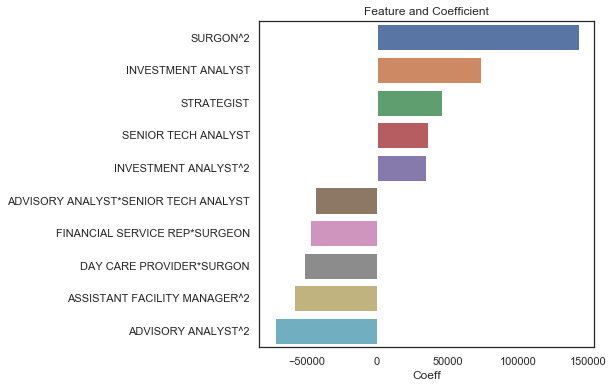

In [1111]:
plt.figure(figsize=(6,6))
sns.set(style='white')
sns.barplot(x='Coeff', y='Feat_Names', data=fc)

plt.ylabel('')
plt.title('Feature and Coefficient')

plt.show()

There are 66 features in the final features including power and interaction of/between those 10 similarity scores. The top 10 features with most magnitude in coefficient are presented in the figure above. Basically, it tells us the dollar value that each of these features adds to the estimated income. 

In [1162]:
s1 = coeff[coeff['Feature']=='s1']
s2 = coeff[coeff['Feature']=='s2']
s3 = coeff[coeff['Feature']=='s3']
s4 = coeff[coeff['Feature']=='s4']
s5 = coeff[coeff['Feature']=='s5']
s6 = coeff[coeff['Feature']=='s6']
s7 = coeff[coeff['Feature']=='s7']
s8 = coeff[coeff['Feature']=='s8']
s9 = coeff[coeff['Feature']=='s9']
s10 = coeff[coeff['Feature'] == 's10']

simscore = pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10])
simscore = simscore.sort_values(['Coef'])

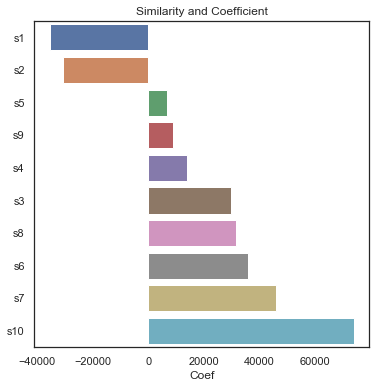

In [1163]:
plt.figure(figsize=(6,6))
sns.set(style='white')
sns.barplot(x='Coef', y='Feature', data=simscore)

plt.ylabel('')
plt.title('Similarity and Coefficient')

plt.show()

Let's take a look at those 10 similarity scores and their coefficients. As we can see from the plot below, s1 and s2 are assoicated with negative value in predicting annual income, while s10 is associated with the highest positive followed by s7, s6, s8, s3, s4, s9, and s5. Most of them are expected except for s3/s4, s5, s8 and s9. One reason could be there are inadequate examples for each job title. The other reason could be these seleted titles don't represent the group based on salary rank very well. 

# Future Work 

The study is of limitations. Future improvement will made in the following aspects:
- Add time series data
- Find more data for each zip code 
- Incorporate numeric geographic variables if possible 
- Chose those titles more rigorously by looking for the most common title in each of 5 levels in the income range